#  Local Data Tutorial
In this tutorial, rather than running real models and configurations over MIMIC-IV, we'll work with a set of
local, synthetic files distributed with this repository, with the goal being to fully explore the details of
this pipeline. This tutorial will consist of both content on this page, running certain scripts on one's local
machine, and some jupyter notebooks. We will walk through the entire pipeline with these local examples and
discuss limitations of the pipeline, details of classes, scripts, etc.

We'll use rootutils to ensure that our notebook is running from the root of the ESGPT repository, to make imports easier. We'll also delete any pre-existing processed data so that this tutorial can run from scratch, every time. To that end, **don't re-run this cell repeatedly in the middle of running this tutorial -- it will delete partial files!**

In [1]:
import os
import rootutils
import shutil

root = rootutils.setup_root(os.path.abspath(''), dotenv=True, pythonpath=True, cwd=True)
shutil.rmtree("sample_data/processed", ignore_errors=True)

## Synthetic Data
For this tutorial, we'll use the three synthetic data files distributed in the sample_data/raw folder in
the repository:

In [2]:
!ls --color sample_data/raw

admit_vitals.csv  labs.csv  medications.csv  subjects.csv


To see how those files are generated, look at sample_data/generate_synthetic_data.py

These files contain the following data:

### `subjects.csv`

This file contains per-subject data. It has one row per subject, with each row containing a subject identifier (here called "`MRN`"), a date of birth ("`dob`"), the subject's eye color (`eye_color`), and the subject's height ("`height`"):

In [3]:
import polars as pl
pl.Config.set_tbl_cols(7)

display(pl.read_csv('sample_data/raw/subjects.csv').head(4))

MRN,dob,eye_color,height
i64,str,str,f64
310243,"""07/28/1981""","""GREEN""",178.767932
384198,"""04/15/1985""","""BROWN""",168.319295
520533,"""04/15/1979""","""BROWN""",165.836447
850710,"""08/08/1970""","""HAZEL""",159.721833


### `admit_vitals.csv`

This file contains dynamic data quantifying both fictional subject hospital admissions, and fictional vitals signs measured for those subjects. Each row of this file records a unique vitals sign measurement for a patient, affiliated with the associated admission listed in the row. This means that admission level information is _heavily duplicated_ within this file, which is a phenomena sometimes observed in real data, and something we'll need to account for in our pipeline's setup.

In [4]:
display(pl.read_csv('sample_data/raw/admit_vitals.csv').head(4))

MRN,admit_date,disch_date,department,vitals_date,HR,temp
i64,str,str,str,str,f64,f64
1549363,"""01/04/2010, 06…","""01/14/2010, 11…","""ORTHOPEDIC""","""01/11/2010, 14…",77.1,96.3
415881,"""02/11/2010, 04…","""02/14/2010, 07…","""ORTHOPEDIC""","""02/11/2010, 10…",148.5,95.6
42335,"""03/06/2010, 05…","""03/16/2010, 05…","""CARDIAC""","""03/13/2010, 10…",46.7,101.0
1516810,"""02/11/2010, 23…","""02/22/2010, 23…","""CARDIAC""","""02/12/2010, 16…",94.2,95.2


### `labs.csv`

This file contains dynamic data quantifying fictional subject laboratory test measurements. Each row of this file contains a record of a particular lab test measured for a subject. Note that the lab data is not organized into separate columns for each lab; rather each row contains a pair of a lab test name and the associated value; this is what we call in ESGPT a "multivariate regression" column encoding.

In [5]:
display(pl.read_csv('sample_data/raw/labs.csv').head(4))

MRN,timestamp,lab_name,lab_value
i64,str,str,f64
1006798,"""10:26:00-2010-…","""SpO2""",53.0
739156,"""20:45:44-2010-…","""SpO2""",51.0
426870,"""00:25:02-2010-…","""SpO2""",50.0
338121,"""17:19:16-2010-…","""GCS""",1.0


## Processing Synthetic Data with ESGPT

Now that we see the form of this synthetic data, we can examine how to process it with Event Stream GPT. From
the base directory of the ESGPT repository, we can run the following command:

```bash
PYTHONPATH=$(pwd):$PYTHONPATH ./scripts/build_dataset.py \
	--config-path="$(pwd)/sample_data/" \
	--config-name=dataset \
	"hydra.searchpath=[$(pwd)/configs]"
```

Note that this script, like all built-in ESGPT scripts, uses [Hydra](https://hydra.cc/), a configuration file and experiment run-script library. In hydra, all scripts can take as input a set of composable configuration files which can be overwritten via files or via the command line. If you aren't already familiar with Hydra, you should read through some of their examples or tutorials to gain some familiarity with their system.

Before we actually run this command, we need to do 2 things:

  1. Decide what we _want_ the command to do, conceptually.
  2. Understand what we're _telling_ the library to do, via its input arguments.
  
### What do we _want_ to happen?
We can see that our synthetic data has a few different kinds of things happening to these subjects. In the ESGPT data model, we want to organize this data so that we clearly know who our subjects are, quantify when things happen to those subjects, and record in a sparse manner what is happening to those patients. Let's list a few more specific desiderata:

  1. We should expect our system to quantify those subjects in our synthetic data that meet our inclusion criteria (which we haven't yet specified).
  2. The system should bucket all interactions for subjects into appropriately defined events, across admissions, discharges, vitals signs, and laboratory tests.
  3. The system should learn appropriate categorical vocabularies, numerical outlier detector models, numerical normalization models, for the various measurements we want to extract (which we haven't yet specified).
  4. The system should produce "deep-learning friendly" representations of these data.

A quick tangent -- what do we mean by "deep-learning friendly" representations of these data? Well, right now, if we were to try to run these data through _any_ deep-learning system for longitudinal data, we'd need to re-format these data such that it is easy to efficiently (ideally $O(1)$) retrieve all data corresponding to a single subject in an organized timeseries format that we can then efficiently (meaning in a manner requiring minimal GPU memory) pass into a sequential neural network. 

In the current representation, this retrieval process would not be $O(1)$; instead, if we didn't modify the data's organization at all, for each new MRN, we'd need to select from each data file all those rows with that MRN (each selection being an $O(N)$ operation), and then we would need to subsequently sort all the temporal data by timestamp (another $O(L\ln(L))$ operation).

Similarly, if we use a naive, dense encoding of the data per measurement for our DL representation, this will be very wasteful in terms of GPU memory, as each record will need to occupy memory proportionate to the total number of possible measurements we could observe in our data (e.g., the total number of lab tests, plus the total number of vitals signs, plus the total number of admission departments, etc.). Instead, a sparse encoding should be used.

These two properties are exactly what we mean by a "deep-learning friendly" representation of the data.

We can see that there are several questions posed by these desiderata that we need to answer, such as:

  1. What are our inclusion criteria?
  2. How should we bucket interactions into events?
  3. What measurements do we want to extract?
  4. How do we want to define "outliers"?
  5. How do we define "appropriate categorical vocabularies"?
  6. How do we want to normalize numerical measurements?
  
To start us off, let's use the following answers:

  1. We'll include all subjects who have at least 3 events, with no other inclusion/exclusion criteria.
  2. We'll define an "event" to be any interactions happening to a patient within a 1 hour period. We'll bucket these interactions together starting at the earliest event.
  3. Ideally, we'd like to extract _all_ measurements. As we'll see, however, due to a limitation in the current version of ESGPT, we'll extract all measurements except for the patient's height. In particular, we'll extract the occurrence of admissions, discharges, vitals signs, and laboratory tests, as well as the subject's age, eye color,  admission department, the values recorded for HR and temperature, and all lab test values.
  4. We'll use a very simple outlier model, that excludes numerical data as outliers if their values exceed 1.5 standard deviations from the mean. This is an extremely aggressive cutoff only suitable for this synthetic data setting.
  5. We'll keep any categorical observation as a vocabulary element if it occurs at least 5 times.
  6. We'll normalize our numerical observations to have zero mean and unit variance.
  
### Telling the pipeline what to do: input config
Now that we have some basic idea of what we want the pipeline to do, let's examine the input configuration file that we pass to the dataset script:

In [6]:
!cat sample_data/dataset.yaml

defaults:
  - dataset_base
  - _self_

# So that it can be run multiple times without issue.
do_overwrite: True

cohort_name: "sample"
subject_id_col: "MRN"
raw_data_dir: "./sample_data/raw/"
save_dir: "./sample_data/processed/${cohort_name}"

DL_chunk_size: null

inputs:
  subjects:
    input_df: "${raw_data_dir}/subjects.csv"
  admissions:
    input_df: "${raw_data_dir}/admit_vitals.csv"
    start_ts_col: "admit_date"
    end_ts_col: "disch_date"
    ts_format: "%m/%d/%Y, %H:%M:%S"
    event_type: ["OUTPATIENT_VISIT", "ADMISSION", "DISCHARGE"]
  vitals:
    input_df: "${raw_data_dir}/admit_vitals.csv"
    ts_col: "vitals_date"
    ts_format: "%m/%d/%Y, %H:%M:%S"
  labs:
    input_df: "${raw_data_dir}/labs.csv"
    ts_col: "timestamp"
    ts_format: "%H:%M:%S-%Y-%m-%d"
  medications:
    input_df: "${raw_data_dir}/medications.csv"
    ts_col: "timestamp"
    ts_format: "%H:%M:%S-%Y-%m-%d"
    columns: {"name": "medication"}

measurements:
  static:
    single_label_classification:
   

There are a number of sections in this file. Firstly, the first three lines ensure this config builds on the defaults provided with the ESGPT library, via Hydra's normal mechanisms. If you aren't familiar with this syntax, check out the [Hydra documentation](https://hydra.cc/docs/1.3/advanced/defaults_list/).

Next, there is a section defining some overarching variables and a section defining our input sources. We can see this section details the paths to each of our input files as well as the formatting used for (most of) the timestamps within these files. Note that this section makes use of [Hydra/OmegaConf's Interpolations](https://omegaconf.readthedocs.io/en/2.3_branch/grammar.html#interpolation-strings) to simplify the specification of the file paths used. 

**Warning**: Two parameters in this section are required: `subject_id_col`, and `cohort_name`. This will be explored in more detail later in this tutorial.

Next, we have a section defining the various measurements we'll exctract in this dataset. We can see we specify each of the measurements we discussed above:
  1. `eye_color` is extracted as a `static`, `single_label_classification` measure. 
  2. `age` is extracted as a `functional_time_dependent` measure, leveraging the date-of-birth column `dob`. _Note that this is where we define the timestamp format for the `dob` column, as it is a timestamp formatted static column!_
  3. `department` is extracted as a `dynamic`, `multi_label_classification` measure.
  4. `HR`, and `temp` are extracted as `dynamic`, `univariate_regression` measures.
  5. `lab_name` and `lab_value` are extracted as a single `dynamic`, `multivariate_regression` measure.
  
Note that the terms `static`, `functional_time_dependent`, & `dynamic` and `single_label_classification`, `multi_label_classification`, `univariate_regression`, and `multivariate_regression`, are defined enumerations in the `EventStream.data.config` sub-module, and dictate where measurements are stored and how they are pre-processed.
  
Finally, we have the remaining set of parameters, which define our inclusion-exclusion criteria (by specifying `min_events_per_subject`), our outlier and normalizer model configuration parameters (`normalization` being omitted here as what we want is the default value), our filtering thresholds for vocabulary elements, and the aggregation time-scale for events.

#### What else _could_ we have specified?
To better understand the structure of this input specification, let's explore this input configuration file in a bit more detail. To start with, let's look at what the default, base config contains (the config we inherit from in the defaults list):

In [7]:
!cat configs/dataset_base.yaml

defaults:
  - outlier_detector_config: stddev_cutoff
  - normalizer_config: standard_scaler
  - _self_

cohort_name: ???
save_dir: ${oc.env:PROJECT_DIR}/data/${cohort_name}
subject_id_col: ???
seed: 1
split: [0.8, 0.1]
do_overwrite: False
DL_chunk_size: 20000
min_valid_vocab_element_observations: 25
min_valid_column_observations: 50
min_true_float_frequency: 0.1
min_unique_numerical_observations: 25
min_events_per_subject: 20
agg_by_time_scale: null

hydra:
  job:
    name: build_${cohort_name}
  run:
    dir: ${save_dir}/.logs
  sweep:
    dir: ${save_dir}/.logs


We can see there are some parameters we're familiar with and some we're not. Firstly, we can see that this default base config marks `cohort_name` and `subject_id_col` with `???`. This is the OmegaConf provided value to represent a value that _needs to be overwritten_ in downstream usage. This is why those two parameters are mandatory. This config also has variables for the seed, split size, and some hydra-internal parameters. Further, it points to two  further default configs for the outlier detector and normalizer:

In [8]:
!cat configs/outlier_detector_config/stddev_cutoff.yaml

cls: stddev_cutoff
stddev_cutoff: 5.0


In [9]:
!cat configs/normalizer_config/standard_scaler.yaml

cls: standard_scaler


These are both quite simple, but show how the final config will be constructed from these values. 

One thing that is notably missing from this broader structure is any notion of included `inputs` or `measurements` sections. To understand how we can further specify our config, we need to understand how we could modify those sections as well.

##### Inputs
This section allows us to specify which input data frames should be read, and from where. The `inputs:` option should be an object whose keys are the names of input sources and whose values are configuration for those inputs. Currently, two input formats are possible:

  1. The `input_df` format, which is used in this synthetic example. This format has an input configuration that contains the `input_df:` key whose value is a file path pointing to a `csv` or `parquet` data-frame file on disk that contains that input source's data. For example:
  ```yaml
admissions:
    input_df: "${raw_data_dir}/admit_vitals.csv"
    start_ts_col: "admit_date"
    end_ts_col: "disch_date"
    ts_format: "%m/%d/%Y, %H:%M:%S"
    event_type: ["OUTPATIENT_VISIT", "ADMISSION", "DISCHARGE"]
  ```
  2. The `query` format, which is used in the MIMIC-IV tutorial. In this format, you must specify a `query` parameter. This parameter can either be a string query or a list of string queries, in which case you must specify a global `connection_uri` parameter detailing the URI of the database to which you wish to query (In the [connector-x](https://github.com/sfu-db/connector-x) format), or a dictionary, with keys and values specifying parameters of the [`EventStream.data.dataset_polars.Query`]() object. For example:
  ```yaml
patients:
    query: |-
      SELECT subject_id, gender, to_date((anchor_year-anchor_age)::CHAR(4), 'YYYY') AS year_of_birth
      FROM mimiciv_hosp.patients
      WHERE subject_id IN (
        SELECT long_icu.subject_id FROM (
          (
            SELECT subject_id FROM mimiciv_icu.icustays WHERE los > ${min_los}
          ) AS long_icu INNER JOIN (
            SELECT subject_id
            FROM mimiciv_hosp.admissions
            GROUP BY subject_id
            HAVING COUNT(*) > ${min_admissions}
          ) AS many_admissions
          ON long_icu.subject_id = many_admissions.subject_id
        )
      )
    must_have: ["gender", "year_of_birth"]
  ```
  
Each input can also have a number of other keys and values, including:

###### Timestamp & Event-type Specification.
For non-static data sources, the keys `ts_col` or `start_ts_col` and `end_ts_col` specify the name of the column (or columns) containing the timestamp for the event, and `ts_format` the format of that timestamp. `ts_col` is used for data-sources where each row represents one event, and `start_`/`end_ts_col` for data-sources where each row specifies a range in time. For example, in our synthetic config,
```yaml
admissions:
    input_df: "${raw_data_dir}/admit_vitals.csv"
    start_ts_col: "admit_date"
    end_ts_col: "disch_date"
    ts_format: "%m/%d/%Y, %H:%M:%S"
    event_type: ["OUTPATIENT_VISIT", "ADMISSION", "DISCHARGE"]
```

specifies a range event, where the start timestamp is stored in `admit_date` and the end timestamp in `disch_date`, formatted as `"%m/%d/%Y, %H:%M:%S"`. In contrast,

```yaml
labs:
    input_df: "${raw_data_dir}/labs.csv"
    ts_col: "timestamp"
    ts_format: "%H:%M:%S-%Y-%m-%d"
```

captures data where each row is a single-timepoint event, with timestamp stored in `"%H:%M:%S-%Y-%m-%d"` format in column `timestamp`.

You can also explicitly set the type of each event. Events' types in ESGPT are categorical variables defined by the user that are used to dictate any intra-event causal dependency graphs in downstream models, can be used to help define downstream tasks, and are otherwise used to analyze and describe data. When using the pre-defined build dataset script, they can either be explicitly set or are automatically inferred from the name of the input block. For example, in the examples given above, the `labs:` block produces an input source with the event type `LAB` (the singular, upper-cased inflection of the name of the block, `'labs'`), and `admissions` (being a range event) produces events of type `'OUTPATIENT_VISIT'` when `admit_date == disch_date` and `'ADMISSION'` on `admit_date` and `'DISCHARGE'` on `disch_date`. For range events, the default event types are defined to be `*_EQ`, `*_START`, and `*_END`, where `*` is the singular, upper-cased inflection of the input block name.

Event types can also be defined to be column dependent. For example, in this config example (which is not part of our current synthetic example config), we see that event types are defined to take on the value of the column `'visit_occurrence_concept_name'` for the case that the start and end times are the same and for start events, but the static `'Drug Stop'` for end events.

```yaml
drugs:
    input_df: "${raw_data_dir}/drug.parquet"
    start_ts_col: "drug_exposure_start_datetime"
    end_ts_col: ["drug_exposure_end_datetime", "verbatim_end_date"]
    event_type: ["COL:visit_occurrence_concept_name", "COL:visit_occurrence_concept_name", "Drug Stop"]
    start_columns: {"standard_concept_name": "drug", "drug_type_concept_name": "drug_type"}
    end_columns: 
        standard_concept_name: drug
        drug_type_concept_name: drug_type
        stop_reason: drug_stop_reason
```

###### Filtering
You can also specify a simple filter used for a given input source. For example, in the `patients` block in the MIMIC-IV example, we specify that valid rows must have `'gender'` and `'year_of_birth'` defined and non-null. This is another way to enforce cohort inclusion/exclusion criteria. The filter object can either be a list of strings, in which case those columns must have non-null values, or a dictionary from column names to either the boolean `True` (indicating the column must be present and non-null) or lists of allowable values for that column.

###### Measurement columns to extract
You can also specify which measurements should be extracted to associate with a given input data source. Largely, this information will be determined automatically based on the `measurements` section of the config; however, it can be specified explicitly as well. The most common case this would be done is to differentiate different measurements to associate with `start` and `end` events for range events or to re-name measurements from their input column names to new names for internal use (this can be done not only for cosmetic reasons, but so as to unify or disentangle measurements across different input files). For example, in the `drugs:` example shown above, the columns `standard_concept_name` and `drug_type_concept_name` are both used for both start and end events, and are renamed to `'drug'`, and `'drug_type'` in both cases, whereas `stop_reason` is used only for end events (and is renamed to `drug_stop_reason`).
##### Measurements Section
The `measurements:` block lists all the actual measurements that should be extracted from those input sources, broken down into categories based on their `temporality` and `modality` (see `EventStream.data.types.TemporalityType` and `EventStream.data.types.DataModality`, respectively). 

The only non-standard portion of this block corresponds to the `functional_time_dependent` block, which specifies measurements whose values are _not_ stored in the raw input data by default, but are instead computable dynamically given per-subject static data and the timestamps of other events that occur in the data. A good example is a subject's age, which is included in our synthetic configuration. Given a subject's date-of-birth and the timestamp of any other event, we can dynamically compute the subject's age as of that event, which is exactly what the `EventStream.data.time_dependent_functor.AgeFunctor` does.

The structure of this config section is
```yaml
functional_time_dependent:
  output_measurement_name:
      functor: ??? # The functor that is used for this measurement. Must be in `EventStream.data.config.MeasurementConfig.FUNCTORS`
      necessary_static_measurements: { "static_measurement_column": ??? } # column name: column formatting info
      kwargs: { kwarg: kwval } # Keyword args to pass to functor constructor.
```

Currently, only [`AgeFunctor`]() and [`TimeOfDayFunctor`] are pre-defined and supported, but this can be extended by the user by directly adding new functors to the [`EventStream.data.config.MeasurementConfig`]() object.

### Running the Command
Now that we understand the setup a bit better, let's run the actual command:

```bash
PYTHONPATH=$(pwd):$PYTHONPATH ./scripts/build_dataset.py \
	--config-path="$(pwd)/sample_data/" \
	--config-name=dataset \
	"hydra.searchpath=[$(pwd)/configs]"
```

To make this notebook self sufficient, we'll run it here via the [`subprocess`]() module:

In [10]:
import subprocess

command = """\
PYTHONPATH=$(pwd):$PYTHONPATH ./scripts/build_dataset.py \
 --config-path="$(pwd)/sample_data/" \
 --config-name=dataset \
 "hydra.searchpath=[$(pwd)/configs]" """

command_out = subprocess.run(command, shell=True, capture_output=True)
print(command_out.stdout.decode())

if command_out.returncode == 1:
    print("Command Errored!")

print(command_out.stderr.decode())


2024-04-22 10:21:50.814 | DEBUG    | EventStream.data.dataset_polars:_load_input_df:183 - Loading df from ./sample_data/raw//subjects.csv
2024-04-22 10:21:50.816 | DEBUG    | EventStream.data.dataset_base:__init__:530 - Extracting events and measurements dataframe...
2024-04-22 10:21:50.816 | DEBUG    | EventStream.data.dataset_polars:_load_input_df:183 - Loading df from ./sample_data/raw//admit_vitals.csv
2024-04-22 10:21:50.816 | DEBUG    | EventStream.data.dataset_base:build_event_and_measurement_dfs:239 - Processing Range
2024-04-22 10:21:50.817 | DEBUG    | EventStream.data.dataset_polars:_process_events_and_measurements_df:319 - Processing OUTPATIENT_VISIT via {'department': ('department', <InputDataType.CATEGORICAL: 'categorical'>)}
2024-04-22 10:21:50.817 | DEBUG    | EventStream.data.dataset_polars:_process_events_and_measurements_df:319 - Processing ADMISSION via {'department': ('department', <InputDataType.CATEGORICAL: 'categorical'>)}
2024-04-22 10:21:50.817 | DEBUG    | E

You should see as output logs of the process,  concluding successfully after caching the DL representations. Before we proceed further, let's break down what this process has done, and how it could do things differently. 

Firstly, let's take a look at what is produced in the output folder itself.

In [11]:
!du -sh sample_data/processed/sample/

2.7M	sample_data/processed/sample/


In [12]:
!ls --color -R sample_data/processed/sample

sample_data/processed/sample:
config.json                      inferred_measurement_configs.json
DL_reps                          inferred_measurement_metadata
dynamic_measurements_df.parquet  input_schema.json
E.pkl                            subjects_df.parquet
events_df.parquet                vocabulary_config.json
hydra_config.yaml

sample_data/processed/sample/DL_reps:
held_out_0.parquet  train_0.parquet  tuning_0.parquet

sample_data/processed/sample/inferred_measurement_metadata:
age.csv  HR.csv  lab_name.csv  temp.csv


Now, let's walk through what happens when we run this script, step-by-step, and how each of the files listed above are produced.

#### Step 1: Config Parsing
First, the script parses our input config file into a slightly refined structured form, then passes that as input to the `EventStream.data.dataset_polars.Dataset` constructor.

To see what this process looks like, we can inspect one portion of the output of the overall script, which we can find in the [sample_data/processed/sample]() directory; in particular, the `input_schema.json` file.

Note that the `sample_data/processed/sample` directory is the `save_dir` key in our `dataset.yaml` configuration file.

In [13]:
!cat sample_data/processed/sample/input_schema.json | python -m json.tool

{
    "static": {
        "input_df": "./sample_data/raw//subjects.csv",
        "type": "static",
        "event_type": null,
        "subject_id_col": "MRN",
        "ts_col": null,
        "start_ts_col": null,
        "end_ts_col": null,
        "ts_format": null,
        "start_ts_format": null,
        "end_ts_format": null,
        "data_schema": [
            {
                "eye_color": "categorical",
                "dob": [
                    "dob",
                    [
                        "timestamp",
                        "%m/%d/%Y"
                    ]
                ]
            }
        ],
        "start_data_schema": null,
        "end_data_schema": null,
        "must_have": []
    },
    "dynamic": [
        {
            "input_df": "./sample_data/raw//admit_vitals.csv",
            "type": "range",
            "event_type": [
                "OUTPATIENT_VISIT",
                "ADMISSION",
                "DISCHARGE"
            ],
            "subjec

This object, stored in JSON format, is an instance of the `EventStream.data.config.DatasetSchema` object; interested readers can read more about it's specific formatting requirements there. We can see that this contains much of the same information as was in the initial `dataset.yaml` config shown above, now with some additional data added as well, such as recognizing that the `"lab_name"` column should be read in as a categorical type and `"lab_value"` as a float type.

Beyond the input data schema, the model also writes out the ESGPT's input overall config object to disk, which stores information about which measurements the pipeline is instructed to extract. That object is stored in `config.json`:

In [14]:
!cat sample_data/processed/sample/config.json | python -m json.tool

{
    "measurement_configs": {
        "eye_color": {
            "name": "eye_color",
            "temporality": "static",
            "modality": "single_label_classification",
            "observation_rate_over_cases": null,
            "observation_rate_per_case": null,
            "functor": null,
            "vocabulary": null,
            "values_column": null,
            "_measurement_metadata": null,
            "modifiers": null
        },
        "department": {
            "name": "department",
            "temporality": "dynamic",
            "modality": "multi_label_classification",
            "observation_rate_over_cases": null,
            "observation_rate_per_case": null,
            "functor": null,
            "vocabulary": null,
            "values_column": null,
            "_measurement_metadata": null,
            "modifiers": null
        },
        "medication": {
            "name": "medication",
            "temporality": "dynamic",
            "modality":

Again, much of this information is simply a more verbose re-arrangement of the data specified in `dataset.yaml`. Notably, no information about the measurements has yet been filled in from the data, though it will eventually be added.

This config structure illustrates a capability of the pipeline outside of the traditional input script format; namely, if one constructs the full config manually, one can pre-specify various measurement specific values (such as vocabulary, normalization parameters, etc.) to be used over what would be inferred from the data.

There is also the full, expanded hydra config stored in `hydra_config.yaml`, which can help aid in reproducibility.

The final input to the constructor of the `EventStream.data.dataset_polars.Dataset` class can be seen in the documentation for its base class, `EventStream.data.dataset_base.DatasetBase` and takeas input:

  1. A `config` object (like that shown in JSON form above.
  2. Either the `subjects_df`, `events_df`, and `dynamic_measurements_df` dataframes directly or an `input_schema` `EventStream.data.config.DatasetSchema` object which is shown in `input_schema.json` above, which is used to construct the three dataframes from source. Currently, the immediate extraction output is not written to disk at all, so we can't directly inspect the `subjects_df`, `events_df`, and `dynamic_measurements_df` that result from our `input_schema`, but we can see their relative structure from the final, pre-processed dataframes which are written to disk, which we'll explore next.

#### Step 2: Data reading and pre-processing
After normalizing the input configs, the pipeline next extracts the data from source and performs pre-processing on these dataframes. This pre-processing encompasses several steps, including:

  1. Minimizing data types to minimizing memory/disk footprint.
  2. Splitting data into train, hyperparameter tuning, and held out test sets.
  3. Identifying categorical variable vocabularies.
  4. Converting appropriate numerical variables to categorical.
  5. Fitting numerical outlier detectors and normalizers.
  6. Normalizing numerical data, removing outliers and infrequent vocabulary elements, and writing out processed `subjects_df`, `events_df`, and `dynamic_measurements_df` parquet files.

##### Pre-processed Data Frames
After this process is complete, we gain the following three files. Note that we'll inspect the files manually here, but you can also load the dataset object and inspect them that way, which we'll do below.

In [15]:
!ls --color sample_data/processed/sample/*_df.parquet

sample_data/processed/sample/dynamic_measurements_df.parquet
sample_data/processed/sample/events_df.parquet
sample_data/processed/sample/subjects_df.parquet


In [16]:
# We use polars to look at these parquet files:
import polars as pl
pl.Config.set_tbl_cols(7)

display(pl.scan_parquet('sample_data/processed/sample/subjects_df.parquet').head(4).collect())

subject_id,eye_color,dob
u32,cat,datetime[μs]
310243,"""GREEN""",1981-07-28 00:00:00
384198,"""BROWN""",1985-04-15 00:00:00
520533,"""BROWN""",1979-04-15 00:00:00
850710,"""HAZEL""",1970-08-08 00:00:00


The subjects dataframe `subjects_df` contains subject IDs (which have been re-named and normalized to occupy the minimal possible `uint` type (here `uint8`), and contains a categorical `eye_color` column for our static measurement, but `height` has been dropped as it wasn't included in our config.

In [17]:
display(pl.scan_parquet('sample_data/processed/sample/events_df.parquet').head(4).collect())

subject_id,timestamp,event_type,event_id,age,age_is_inlier
u32,datetime[μs],cat,u64,f64,bool
15267,2010-04-23 04:16:29,"""ADMISSION&VITA…",9159188870894337796,0.205934,true
15267,2010-04-23 05:16:29,"""LAB""",9567702754158037042,0.205961,true
15267,2010-04-23 06:16:29,"""LAB""",17065118070841774664,0.205987,true
15267,2010-04-23 07:16:29,"""VITAL&LAB""",7840165013239040979,0.206013,true


The events dataframe `events_df` contains event IDs, subject IDs, timestamps, event types, and our only functional time dependent measurement, `age`, in normalized form, alongside an inlier/outlier indicator column. We can also see several other properties:
  1. That these data are sorted, first by `subject_id` then by `event_id` (equivalently, by `timestamp`).
  2. That event timestamps are separated by precisely 1 hour, which was our input aggregation window.
  3. That event types have been aggregated into merged categories during aggregation. E.g., event 1 with event type `VITAL&LAB` reflects that events of type `VITAL` and `LAB` have been merged together. This is to ensure that no subject has two distinct events at the same timestamp.

In [18]:
df = pl.scan_parquet('sample_data/processed/sample/dynamic_measurements_df.parquet')
print("Dynamic Measurement Columns:\n  * " + '\n  * '.join(df.columns))
display(df.head(4).collect())

Dynamic Measurement Columns:
  * measurement_id
  * department
  * HR
  * temp
  * lab_name
  * lab_value
  * medication
  * dose
  * frequency
  * duration
  * generic_name
  * event_id
  * HR_is_inlier
  * temp_is_inlier
  * lab_name_is_inlier


measurement_id,department,HR,…,HR_is_inlier,temp_is_inlier,lab_name_is_inlier
u32,cat,f64,…,bool,bool,bool
0,"""CARDIAC""",null,…,null,null,null
1,"""CARDIAC""",null,…,null,null,null
2,"""ORTHOPEDIC""",null,…,null,null,null
3,"""PULMONARY""",null,…,null,null,null


The dynamic measurements dataframe `dynamic_measurements_df` has an ID column, an `event_id` linking column, and then all our measurements, recorded with missingness.

##### Fit Measurement Properties
In all of these dataframes, we can see the outputs from our learned vocabularies, outlier detector models, and normalizer models. How can we determine what fit parameters were used to make those distinctions? These data are stored in the `inferred_measurement_metadata` objects. The overall container is stored in `inferred_measurement_configs.json`, which contains an object linking measurement names to overall configs:

In [19]:
!cat sample_data/processed/sample/inferred_measurement_configs.json | python -m json.tool

{
    "eye_color": {
        "name": "eye_color",
        "temporality": "static",
        "modality": "single_label_classification",
        "observation_rate_over_cases": 1.0,
        "observation_rate_per_case": 1.0,
        "functor": null,
        "vocabulary": {
            "vocabulary": [
                "UNK",
                "BROWN",
                "BLUE",
                "HAZEL",
                "GREEN"
            ],
            "obs_frequencies": [
                0.0,
                0.525,
                0.1875,
                0.175,
                0.1125
            ]
        },
        "values_column": null,
        "_measurement_metadata": null,
        "modifiers": null
    },
    "department": {
        "name": "department",
        "temporality": "dynamic",
        "modality": "multi_label_classification",
        "observation_rate_over_cases": 0.012515953723907942,
        "observation_rate_per_case": 1.0,
        "functor": null,
        "vocabulary": {
      

We can see that these objects contain the full vocabularies learned, as well as (for numerical measurements) internal links to further measurement metadata `csv` files. These `csv` files contain more detailed statistics for numerical data, such as outlier detector and normalizer models. Let's inspect two of these, one for the `multivariate_regression` measurement `lab_name` and one for the `univariate_regression` measurement `age`:

In [20]:
display(pl.read_csv('sample_data/processed/sample/inferred_measurement_metadata/lab_name.csv').head(4))

lab_name,value_type,outlier_model,normalizer
str,str,str,str
"""potassium""","""float""","""{'thresh_large…","""{'mean_': 4.53…"
"""SOFA""","""categorical_in…","""{'thresh_large…","""{'mean_': None…"
"""SpO2""","""integer""","""{'thresh_large…","""{'mean_': 56.1…"
"""creatinine""","""float""","""{'thresh_large…","""{'mean_': 1.01…"


We can see that the `lab_name.csv` file contains a dataframe mapping the `lab_name` (the categorical component of this multivariate regression task) to the inferred `value_type` (whether the value is a `float`, `integer`, `categorical_float`, or `categorical_integer`), `outlier_model` parameters, and `normalizer` parameters. From this, we can see that the `GCS` lab test has been interpreted as a `categorical_integer`, and from the `vocabulary` in the prior JSON object, we can see that it takes on values ranging from 1 to 15. In contrast, we can see that the `SpO2` lab value is a float a mean of 50.9 (which, to be clear, is a _bad_ real-world SpO2), and has an inferred outlier threshold of approximately $\pm15000$. 

In [21]:
display(pl.read_csv('sample_data/processed/sample/inferred_measurement_metadata/age.csv').head(4))

,age
str,str
"""value_type""","""float"""
"""outlier_model""","""{'thresh_large…"
"""normalizer""","""{'mean_': 30.8…"


In contrast to the `multivariate_regression` measurement file, the `univariate` `age.csv` file contains a series representation mapping the three non-categorical-index columns of the prior file to their unique value for `age` alone. We can see that `age` is a floating point value, with a mean of $31.4\pm 4.5$ within the "inlier" range of $22.9 - 39.4$.

##### Inspecting the dataset object.
We can also look at the same content through the actual object oriented dataset interface, which contains all the above information and more, as loaded through some of the other files in this directory, such as `E.pkl` which contains other dataset attributes. Let's do this now.

In [22]:
# Imports
from pathlib import Path

from EventStream.data.dataset_polars import Dataset

In [23]:
dataset_dir = Path("sample_data/processed/sample")

With the dataset loaded, we can ask about the three dataframes we inspected above...

In [24]:
ESD = Dataset.load(dataset_dir)

2024-04-22 10:21:54.421 | INFO     | EventStream.data.dataset_base:load:422 - Updating config.save_dir from /home/mmd/Projects/EventStreamGPT/sample_data/processed/sample to sample_data/processed/sample


In [25]:
display(ESD.subjects_df.head(3))
display(ESD.events_df.head(3))
display(ESD.dynamic_measurements_df.head(3))

2024-04-22 10:21:54.472 | INFO     | EventStream.data.dataset_base:subjects_df:348 - Loading subjects from sample_data/processed/sample/subjects_df.parquet...


subject_id,eye_color,dob
u32,cat,datetime[μs]
310243,"""GREEN""",1981-07-28 00:00:00
384198,"""BROWN""",1985-04-15 00:00:00
520533,"""BROWN""",1979-04-15 00:00:00


2024-04-22 10:21:54.476 | INFO     | EventStream.data.dataset_base:events_df:366 - Loading events from sample_data/processed/sample/events_df.parquet...


subject_id,timestamp,event_type,event_id,age,age_is_inlier
u32,datetime[μs],cat,u64,f64,bool
15267,2010-04-23 04:16:29,"""ADMISSION&VITA…",9159188870894337796,0.205934,true
15267,2010-04-23 05:16:29,"""LAB""",9567702754158037042,0.205961,true
15267,2010-04-23 06:16:29,"""LAB""",17065118070841774664,0.205987,true


2024-04-22 10:21:54.482 | INFO     | EventStream.data.dataset_base:dynamic_measurements_df:385 - Loading dynamic_measurements from sample_data/processed/sample/dynamic_measurements_df.parquet...


measurement_id,department,HR,…,HR_is_inlier,temp_is_inlier,lab_name_is_inlier
u32,cat,f64,…,bool,bool,bool
0,"""CARDIAC""",null,…,null,null,null
1,"""CARDIAC""",null,…,null,null,null
2,"""ORTHOPEDIC""",null,…,null,null,null


Or about other properties, such as train-test split membership

In [26]:
ESD.split_subjects['tuning']

{379433,
 383358,
 426870,
 759652,
 820599,
 883221,
 928262,
 1031243,
 1084237,
 1356900}

or vocabulary indices

In [27]:
ESD.unified_vocabulary_idxmap

{'event_type': {'VITAL&LAB': 1,
  'LAB': 2,
  'VITAL': 3,
  'ADMISSION&VITAL&LAB': 4,
  'ADMISSION&VITAL': 5,
  'DISCHARGE': 6,
  'DISCHARGE&LAB': 7,
  'DISCHARGE&VITAL&LAB': 8,
  'VITAL&LAB&MEDICATION': 9,
  'DISCHARGE&VITAL': 10,
  'LAB&MEDICATION': 11,
  'MEDICATION': 12,
  'VITAL&MEDICATION': 13,
  'DISCHARGE&MEDICATION': 14},
 'HR': {'HR': 15},
 'age': {'age': 16},
 'department': {'UNK': 17, 'PULMONARY': 18, 'CARDIAC': 19, 'ORTHOPEDIC': 20},
 'eye_color': {'UNK': 21, 'BROWN': 22, 'BLUE': 23, 'HAZEL': 24, 'GREEN': 25},
 'lab_name': {'UNK': 26,
  'SpO2': 27,
  'potassium': 28,
  'creatinine': 29,
  'SOFA__EQ_1': 30,
  'SOFA__EQ_2': 31,
  'GCS__EQ_1': 32,
  'SOFA__EQ_3': 33,
  'SOFA__EQ_4': 34,
  'GCS__EQ_4': 35,
  'GCS__EQ_3': 36,
  'GCS__EQ_2': 37,
  'GCS__EQ_5': 38,
  'GCS__EQ_6': 39,
  'GCS__EQ_7': 40,
  'GCS__EQ_8': 41,
  'GCS__EQ_9': 42,
  'GCS__EQ_10': 43,
  'GCS__EQ_11': 44,
  'GCS__EQ_12': 45,
  'GCS__EQ_15': 46,
  'GCS__EQ_13': 47,
  'GCS__EQ_14': 48},
 'medication': {'UNK'

And the inferred measurement metadata:

In [28]:
ESD.measurement_configs['age'].measurement_metadata

value_type                                                   float
outlier_model    {'thresh_large_': 38.452687624673466, 'thresh_...
normalizer       {'mean_': 30.87972424022482, 'std_': 4.3255748...
Name: age, dtype: object

... or many other properties. Check out the documentation for `EventStream.data.dataset_base.DatasetBase` for full details.

##### Moving Datasets
Given the various relative files stored in the dataset folder, it's worth double checking that we can natively move and reload the dataset to different locations in the filepath.

In [29]:
!cp sample_data/processed/sample/ sample_data/processed/sample_2 -r

In [30]:
ESD_2 = Dataset.load(Path("sample_data/processed/sample_2"))

print(
    f"ESD_2 has stored save_dir {ESD_2.config.save_dir}, with dataframes stored at\n"
    f"  * {ESD_2.subjects_fp(ESD_2.config.save_dir)}\n"
    f"  * {ESD_2.events_fp(ESD_2.config.save_dir)}\n"
    f"  * {ESD_2.dynamic_measurements_fp(ESD_2.config.save_dir)}\n"
    "\n"
    f"Measurement metadata relative filepaths are now similarly updated:\n"
    f"  * (age): {ESD_2.measurement_configs['age']._measurement_metadata}\n"
    "...\n"
    "Displaying data:"
)
display(ESD_2.subjects_df.head(2))
display(ESD_2.measurement_configs['age'].measurement_metadata)

2024-04-22 10:21:54.659 | INFO     | EventStream.data.dataset_base:load:422 - Updating config.save_dir from /home/mmd/Projects/EventStreamGPT/sample_data/processed/sample to sample_data/processed/sample_2
2024-04-22 10:21:54.686 | INFO     | EventStream.data.dataset_base:subjects_df:348 - Loading subjects from sample_data/processed/sample_2/subjects_df.parquet...


ESD_2 has stored save_dir sample_data/processed/sample_2, with dataframes stored at
  * sample_data/processed/sample_2/subjects_df.parquet
  * sample_data/processed/sample_2/events_df.parquet
  * sample_data/processed/sample_2/dynamic_measurements_df.parquet

Measurement metadata relative filepaths are now similarly updated:
  * (age): [PosixPath('sample_data/processed/sample_2'), 'inferred_measurement_metadata/age.csv']
...
Displaying data:


subject_id,eye_color,dob
u32,cat,datetime[μs]
310243,"""GREEN""",1981-07-28 00:00:00
384198,"""BROWN""",1985-04-15 00:00:00


value_type                                                   float
outlier_model    {'thresh_large_': 38.452687624673466, 'thresh_...
normalizer       {'mean_': 30.87972424022482, 'std_': 4.3255748...
Name: age, dtype: object

#### Step 3: Producing DL-friendly Dataframes
After the dataset pre-processing is done, the data then needs to be re-formatted to produce the deep-learning friendly data representations. These files live in the `DL_reps` subfolder:

In [31]:
!ls --color sample_data/processed/sample/DL_reps/

held_out_0.parquet  train_0.parquet  tuning_0.parquet


What do these datasets contain? Rather than the former arrangement of data across three dataframes, here each row corresponds to all data for a given subject, arranged for maximal sparsity and rapid access to temporal data arranged longitudinally. As such, these dataframes have nested columns containing timepoints, indices, and values for the associated subjects.

In [32]:
df = pl.scan_parquet('sample_data/processed/sample/DL_reps/tuning_*.parquet')
print("DL Dataframe Columns:\n  * " + '\n  * '.join(df.columns))
display(df.head(4).collect())

DL Dataframe Columns:
  * subject_id
  * static_measurement_indices
  * static_indices
  * start_time
  * time
  * dynamic_measurement_indices
  * dynamic_indices
  * dynamic_values


subject_id,static_measurement_indices,static_indices,…,dynamic_measurement_indices,dynamic_indices,dynamic_values
u32,list[u8],list[u8],…,list[list[u8]],list[list[u8]],list[list[f64]]
379433,[5],[23],…,"[[1, 3, … 8], [1, 3, … 6], … [1, 3, … 6]]","[[5, 16, … 55], [2, 16, … 28], … [7, 16, … 28]]","[[null, NaN, … 0.469286], [null, NaN, … -1.553976], … [null, NaN, … 0.669173]]"
383358,[5],[23],…,"[[1, 3, … 8], [1, 3, … 8], … [1, 3, 4]]","[[4, 16, … 55], [1, 16, … 55], … [6, 16, 19]]","[[null, 1.634786, … -0.06663], [null, 1.634813, … 0.254923], … [null, NaN, null]]"
426870,[5],[23],…,"[[1, 3, … 8], [1, 3, … 6], … [1, 3, … 8]]","[[4, 16, … 55], [2, 16, … 27], … [8, 16, … 55]]","[[null, -1.370287, … -1.084867], [null, -1.37026, … 1.36021], … [null, -1.362981, … -1.084867]]"
759652,[5],[22],…,"[[1, 3, … 8], [1, 3, … 6], … [1, 3, … 8]]","[[4, 16, … 55], [2, 16, … 27], … [8, 16, … 55]]","[[null, 0.387592, … 0.147737], [null, 0.387618, … 3.923302], … [null, 0.511306, … 1.648303]]"


In addition to these deep-learning datasets, the pipeline also outputs information about the overall vocabulary of the dataset, into the `vocabulary_config.json` file:

In [33]:
!cat sample_data/processed/sample/vocabulary_config.json | python -m json.tool

{
    "vocab_sizes_by_measurement": {
        "event_type": 14,
        "eye_color": 5,
        "department": 4,
        "medication": 6,
        "lab_name": 23
    },
    "vocab_offsets_by_measurement": {
        "event_type": 1,
        "HR": 15,
        "age": 16,
        "department": 17,
        "eye_color": 21,
        "lab_name": 26,
        "medication": 49,
        "temp": 55
    },
    "measurements_idxmap": {
        "event_type": 1,
        "HR": 2,
        "age": 3,
        "department": 4,
        "eye_color": 5,
        "lab_name": 6,
        "medication": 7,
        "temp": 8
    },
    "measurements_per_generative_mode": {
        "single_label_classification": [
            "event_type"
        ],
        "multi_label_classification": [
            "department",
            "medication",
            "lab_name"
        ],
        "univariate_regression": [
            "HR",
            "temp"
        ],
        "multivariate_regression": [
            "lab_name"
      

### Interacting with DL DataFrames: The Pytorch Dataset
How can we best interact with these DL dataframe representations? We can do so through the provided `EventStream.data.pytorch_dataset.PytorchDataset` class. To create this class, we need to specify a pytorch dataset config object, which contains both (1) a pointer to the directory in which the overall dataset is saved (here `processed/sample`) and (2) other, pytorch dataset specific parameters such as the max sequence length.

For now, let's build a pytorch dataset with a maximum sequence length of 8, to keep things nice and easily inspectable. We'll keep other parameters at their defaults. When you construct a pytorch dataset, you pass in both the config object and a split (`'train'`, `'tuning'`, or `'held_out'`). We'll pull up the train split for now.

In [34]:
from EventStream.data.config import PytorchDatasetConfig
from EventStream.data.types import PytorchBatch
from EventStream.data.pytorch_dataset import PytorchDataset

In [35]:
%%time
pyd_config = PytorchDatasetConfig(
    save_dir=ESD.config.save_dir,
    max_seq_len=8,
)
pyd = PytorchDataset(config=pyd_config, split='train')

2024-04-22 10:21:55.272 | INFO     | EventStream.data.pytorch_dataset:cache_if_needed:122 - Caching the full dataset...
2024-04-22 10:21:55.277 | INFO     | EventStream.data.config:_cache_data_parameters:1033 - Saving data parameters to sample_data/processed/sample/DL_reps/tensorized_cached/9204fc6925deef38/data_parameters.json
2024-04-22 10:21:55.512 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:221 - Saving full data_stats to sample_data/processed/sample/DL_reps/tensorized_cached/9204fc6925deef38/train/data_stats.json
2024-04-22 10:21:55.513 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:224 - Collecting data to cache @ initial seed of 1.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

2024-04-22 10:21:55.585 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:230 - Collating data into dense tensors to cache.


Caching...:   0%|          | 0/11 [00:00<?, ?it/s]

2024-04-22 10:21:55.647 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor event_mask of shape torch.Size([80, 8]) to sample_data/processed/sample/DL_reps/tensorized_cached/9204fc6925deef38/train/event_mask.pt...
2024-04-22 10:21:55.648 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:265 - Done in 0:00:00.000909
2024-04-22 10:21:55.649 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor time_delta of shape torch.Size([80, 8]) to sample_data/processed/sample/DL_reps/tensorized_cached/9204fc6925deef38/train/time_delta.pt...
2024-04-22 10:21:55.650 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:265 - Done in 0:00:00.000559
2024-04-22 10:21:55.650 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor static_indices of shape torch.Size([80, 1]) to sample_data/processed/sample/DL_reps/tensorized_cached/9204fc6925deef38/train/static_indices.pt...
2024-04-22 10:21:55.65

CPU times: user 426 ms, sys: 39.1 ms, total: 465 ms
Wall time: 403 ms


We don't print out any of its data here as it looks very large. But what we can print out is what happens when you call the pytorch built-in `__getitem__` function for a given index:

In [36]:
pyd[0]

{'dynamic_values': tensor([[    nan,  0.3181, -1.5518, -1.5762, -0.5621, -0.5621, -0.5621, -0.4706,
          -1.4600, -1.4064,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan,     nan],
         [    nan,  0.3182, -1.7074, -1.6896, -0.5621, -0.5621, -1.3528, -1.3528,
              nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan,     nan],
         [    nan,  0.3182, -1.6362, -0.4706, -1.5136,     nan,     nan,     nan,
              nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
              nan,     nan,     nan],
         [    nan,  0.3182, -1.6474, -1.5807, -1.4295, -1.5073, -0.3790, -0.2875,
          -1.3528, -1.5136, -1.2992, -1.5136,     nan,     nan,     nan,     nan,
              nan,     nan,     nan],
         [    nan,  0.3182, -1.5273, -1.4739, -1.6140, -0.4706, -1.1385, -0.7633,
          -0.9241,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
          

We can see this returns a dictionary linking names to tensors, but these tensors are not necessarilly all padded to the same length yet. We provide a built-in custom collate function that can be used via `pyd.collate`:

In [37]:
print(f"`pyd.collate` docstring:\n{pyd.collate.__doc__}")

`pyd.collate` docstring:
Combines the ragged dictionaries produced by `__getitem__` into a tensorized batch.

        This function handles conversion of arrays to tensors and padding of elements within the batch across
        static data elements, sequence events, and dynamic data elements.

        Args:
            batch: A list of `__getitem__` format output dictionaries.

        Returns:
            A fully collated, tensorized, and padded batch.
        


#### Producing Batches

Now let's see how the pytorch dataset turns these odd `__getitem__` representations into batches for deep-learning, via the provided `pyd.collate` function:

In [38]:
%%time
batch = pyd.collate([pyd[i] for i in range(4)])

CPU times: user 598 µs, sys: 202 µs, total: 800 µs
Wall time: 543 µs


In [39]:
batch

PytorchBatch(event_mask=tensor([[True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True]]), time_delta=tensor([[60., 60., 60., 60., 60., 60., 60., 60.],
        [60., 60., 60., 60., 60., 60., 60., 60.],
        [60., 60., 60., 60., 60., 60., 60., 60.],
        [60., 60., 60., 60., 60., 60., 60., 60.]]), time=None, static_indices=tensor([[22],
        [22],
        [23],
        [22]]), static_measurement_indices=tensor([[22],
        [22],
        [23],
        [22]]), dynamic_indices=tensor([[[ 1, 16, 15, 15, 27, 27, 27, 27, 55, 55,  0,  0,  0,  0,  0,  0,  0,
           0,  0],
         [ 1, 16, 15, 15, 27, 27, 55, 55,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0],
         [ 1, 16, 15, 27, 55,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0],
         [ 1, 16, 15, 15, 15, 15, 27, 27, 55, 55, 55,

Firstly, we can see that unlike instantiating the pytorch dataset, batch creation and data retrieval is very fast, which is good. Secondly, we can see that the PyTorch Batch object looks similar to the `__getitem__` output except for:

  1. It is an object itself, rather than a plain-old-dictionary (thought it is functionally much like a dictionary).
  2. It contains padded tensors, rather than ragged lists of lists.
  
Fact 2 is the entire reason we provide a specialized collate function; to handle the nested padding and concatenation for you so that you don't need to either have massively over-padded batches or write that code yourself. 

As these batches are objects, what can you do with them? For starters, they have some helpful helper functions:

In [40]:
print(
    f"This batch has a batch size of `batch.batch_size = {batch.batch_size}`, "
    f"a sequence length of `batch.sequence_length = {batch.sequence_length}`, "
    f"with events having no more than `batch.n_data_elements = {batch.n_data_elements}` "
    "measurements per event, and patients having no more than "
    f"`batch.n_static_data_elements = {batch.n_static_data_elements}` static measurements "
    f"per patient. The batch is on device `batch.device = {batch.device}`."
)

This batch has a batch size of `batch.batch_size = 4`, a sequence length of `batch.sequence_length = 8`, with events having no more than `batch.n_data_elements = 19` measurements per event, and patients having no more than `batch.n_static_data_elements = 1` static measurements per patient. The batch is on device `batch.device = cpu`.


You can also slice a batch and have it meaningfully slice sub-patients or sub-events in the batch, e.g.,

In [41]:
print(batch[:-1].batch_size, batch[:, :-3].sequence_length, batch[:, :, :-3].n_data_elements)

3 5 16


where slice dimensions are patient, then sequence, then data elements. 

You can also even repeat patients in a batch, split a batch into a list of chunks, or convert a batch back into the DL representation view of the data (which is used on in select, niche applications related to generation and zero-shot learning). Note that the repeat and split commands only work for batches suitable for generation (meaning including the start time parameter), which our batch here is not.

In [42]:
batch.convert_to_DL_DF()

time_delta,static_indices,static_measurement_indices,dynamic_indices,dynamic_measurement_indices,dynamic_values
list[f64],list[f64],list[f64],list[list[f64]],list[list[f64]],list[list[f64]]
"[60.0, 60.0, … 60.0]",[22.0],[22.0],"[[1.0, 16.0, … 55.0], [1.0, 16.0, … 55.0], … [1.0, 16.0, … 55.0]]","[[1.0, 3.0, … 8.0], [1.0, 3.0, … 8.0], … [1.0, 3.0, … 8.0]]","[[null, 0.318124, … -1.406419], [null, 0.31815, … -1.352824], … [null, 0.318308, … -1.031276]]"
"[60.0, 60.0, … 60.0]",[22.0],[22.0],"[[2.0, 16.0, … 27.0], [1.0, 16.0, … 55.0], … [1.0, 16.0, … 55.0]]","[[1.0, 3.0, … 6.0], [1.0, 3.0, … 8.0], … [1.0, 3.0, … 8.0]]","[[null, 0.866815, … -0.562109], [null, 0.866842, … 1.701894], … [null, 0.867, … 1.701894]]"
"[60.0, 60.0, … 60.0]",[23.0],[23.0],"[[1.0, 16.0, … 55.0], [1.0, 16.0, … 55.0], … [1.0, 16.0, … 55.0]]","[[1.0, 3.0, … 8.0], [1.0, 3.0, … 8.0], … [1.0, 3.0, … 8.0]]","[[null, -0.233202, … -0.173811], [null, -0.233176, … -0.388178], … [null, -0.233018, … -0.548951]]"
"[60.0, 60.0, … 60.0]",[22.0],[22.0],"[[1.0, 16.0, … 55.0], [1.0, 16.0, … 55.0], … [1.0, 16.0, … 55.0]]","[[1.0, 3.0, … 8.0], [1.0, 3.0, … 8.0], … [1.0, 3.0, … 8.0]]","[[null, -1.096418, … 0.362104], [null, -1.096392, … 0.254923], … [null, -1.096233, … 0.308514]]"


Batches have some optional parameters that are only set in select contexts. For example:

##### Generation Parameters:
Batches can have a start time in minutes set for their sampled sub-sequences, which is used during generation but not pre-training. This is controllable via the data config:

In [43]:
pyd_with_st_time = PytorchDataset(
    config=PytorchDatasetConfig(save_dir=ESD.config.save_dir, do_include_start_time_min=True),
    split='tuning'
)
batch_with_st_time = pyd_with_st_time.collate([pyd_with_st_time[i] for i in range(4)])

2024-04-22 10:21:55.830 | INFO     | EventStream.data.pytorch_dataset:cache_if_needed:122 - Caching the full dataset...
2024-04-22 10:21:55.832 | INFO     | EventStream.data.config:_cache_data_parameters:1033 - Saving data parameters to sample_data/processed/sample/DL_reps/tensorized_cached/528b89a129a1e545/data_parameters.json
2024-04-22 10:21:55.862 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:221 - Saving full data_stats to sample_data/processed/sample/DL_reps/tensorized_cached/528b89a129a1e545/tuning/data_stats.json
2024-04-22 10:21:55.862 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:224 - Collecting data to cache @ initial seed of 1.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

2024-04-22 10:21:55.885 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:230 - Collating data into dense tensors to cache.


Caching...:   0%|          | 0/11 [00:00<?, ?it/s]

2024-04-22 10:21:55.997 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor event_mask of shape torch.Size([10, 256]) to sample_data/processed/sample/DL_reps/tensorized_cached/528b89a129a1e545/tuning/event_mask.pt...
2024-04-22 10:21:55.997 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:265 - Done in 0:00:00.000759
2024-04-22 10:21:55.998 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor time_delta of shape torch.Size([10, 256]) to sample_data/processed/sample/DL_reps/tensorized_cached/528b89a129a1e545/tuning/time_delta.pt...
2024-04-22 10:21:55.999 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:265 - Done in 0:00:00.000688
2024-04-22 10:21:55.999 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor static_indices of shape torch.Size([10, 1]) to sample_data/processed/sample/DL_reps/tensorized_cached/528b89a129a1e545/tuning/static_indices.pt...
2024-04-22 10:2

Batches during generation may also pre-compute not just the time deltas, but actually the raw time values as well, but by default this is done during modeling, not in the dataset, so that value is still `None` by default:

In [44]:
batch_with_st_time.time is None

True

Lastly, batches can also be right or left padded, sequentially. This is necessary because while right padding is more traditional (so that the real events occur at the lower indices of the tensor on the sequence axis), left padding is necessary during generation so that all sequences are aligned to end at the end of the real-observed sequence elements. To show the difference between these two, we need to make another dataset with a longer sequence length.

In [45]:
pyd_right_pad = PytorchDataset(
    config=PytorchDatasetConfig(
        save_dir=ESD.config.save_dir, do_include_start_time_min=True, seq_padding_side='right',
        max_seq_len=10000
    ),
    split='tuning'
)
batch_right_pad = pyd_right_pad.collate([pyd_right_pad[i] for i in range(3)])

2024-04-22 10:21:56.118 | INFO     | EventStream.data.pytorch_dataset:cache_if_needed:122 - Caching the full dataset...
2024-04-22 10:21:56.119 | INFO     | EventStream.data.config:_cache_data_parameters:1033 - Saving data parameters to sample_data/processed/sample/DL_reps/tensorized_cached/09cc81ca2ca4b5dc/data_parameters.json
2024-04-22 10:21:56.143 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:221 - Saving full data_stats to sample_data/processed/sample/DL_reps/tensorized_cached/09cc81ca2ca4b5dc/tuning/data_stats.json
2024-04-22 10:21:56.143 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:224 - Collecting data to cache @ initial seed of 1.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

2024-04-22 10:21:56.166 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:230 - Collating data into dense tensors to cache.


Caching...:   0%|          | 0/11 [00:00<?, ?it/s]

2024-04-22 10:21:56.312 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor event_mask of shape torch.Size([10, 567]) to sample_data/processed/sample/DL_reps/tensorized_cached/09cc81ca2ca4b5dc/tuning/event_mask.pt...
2024-04-22 10:21:56.313 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:265 - Done in 0:00:00.000814
2024-04-22 10:21:56.314 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor time_delta of shape torch.Size([10, 567]) to sample_data/processed/sample/DL_reps/tensorized_cached/09cc81ca2ca4b5dc/tuning/time_delta.pt...
2024-04-22 10:21:56.314 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:265 - Done in 0:00:00.000548
2024-04-22 10:21:56.315 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor static_indices of shape torch.Size([10, 1]) to sample_data/processed/sample/DL_reps/tensorized_cached/09cc81ca2ca4b5dc/tuning/static_indices.pt...
2024-04-22 10:2

With this batch (which we make have a very long sequence length so we have some sequences that are for sure padded), we can see that the events are all present on the left, but some are padded on the right.

In [46]:
batch_right_pad.event_mask.shape

torch.Size([3, 567])

In [47]:
batch_right_pad.event_mask[:, :4]

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

In [48]:
batch_right_pad.event_mask[:, -4:]

tensor([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]])

If we build an analogous batch with `seq_padding_side` set to `left`, the behavior will be the opposite.

Note that here we use the enum form of the input for `seq_padding_side`; however, as (almost) all of the enums we use are `StrEnums`, they can be equivalently used in enum form or in string form, where the string equivalent value is the lower-cased version of the enum member name.

In [49]:
from EventStream.data.config import SeqPaddingSide
pyd_left_pad = PytorchDataset(
    config=PytorchDatasetConfig(
        save_dir=ESD.config.save_dir, do_include_start_time_min=True, seq_padding_side=SeqPaddingSide.LEFT,
        max_seq_len=10000
    ),
    split='tuning'
)
batch_left_pad = pyd_left_pad.collate([pyd_left_pad[i] for i in range(3)])

2024-04-22 10:21:56.445 | INFO     | EventStream.data.pytorch_dataset:cache_if_needed:122 - Caching the full dataset...
2024-04-22 10:21:56.446 | INFO     | EventStream.data.config:_cache_data_parameters:1033 - Saving data parameters to sample_data/processed/sample/DL_reps/tensorized_cached/7ad274fe486b6aba/data_parameters.json
2024-04-22 10:21:56.471 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:221 - Saving full data_stats to sample_data/processed/sample/DL_reps/tensorized_cached/7ad274fe486b6aba/tuning/data_stats.json
2024-04-22 10:21:56.472 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:224 - Collecting data to cache @ initial seed of 1.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

2024-04-22 10:21:56.492 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:230 - Collating data into dense tensors to cache.


Caching...:   0%|          | 0/11 [00:00<?, ?it/s]

2024-04-22 10:21:56.636 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor event_mask of shape torch.Size([10, 567]) to sample_data/processed/sample/DL_reps/tensorized_cached/7ad274fe486b6aba/tuning/event_mask.pt...
2024-04-22 10:21:56.637 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:265 - Done in 0:00:00.000792
2024-04-22 10:21:56.638 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor time_delta of shape torch.Size([10, 567]) to sample_data/processed/sample/DL_reps/tensorized_cached/7ad274fe486b6aba/tuning/time_delta.pt...
2024-04-22 10:21:56.638 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:265 - Done in 0:00:00.000676
2024-04-22 10:21:56.639 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor static_indices of shape torch.Size([10, 1]) to sample_data/processed/sample/DL_reps/tensorized_cached/7ad274fe486b6aba/tuning/static_indices.pt...
2024-04-22 10:2

In [50]:
batch_left_pad.event_mask.shape

torch.Size([3, 567])

In [51]:
batch_left_pad.event_mask[:, :4]

tensor([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]])

In [52]:
batch_left_pad.event_mask[:, -4:]

tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])

##### Downstream-task Parameters
Batches can also encode downstream task parameters via the `stream_labels` parameter. We'll see this in more detail later, when we talk about downstream tasks specifically.

Another task dependent parameter within the `PytorchDatasetConfig` object is `subsequence_sampling_strategy`, which dictates whether we choose a sequence of maximal possible length at random from the patient's record or such that it ends at the end of the valid input window or starts at the start of the valid input window.

#### Decoding batch or DL representation values
To "decode" batch or DL values back to the initial representation, we simply need to convert vocabulary indices to vocabulary elements and use the normalization and outlier detector parameters to convert values back to the appropriate range. Let's test this by decoding the first 2 events of the first patient's sampled sub-sequence of the initial batch we created.

In [53]:
first_pt_first_2_events = batch[0, :2]
dynamic_indices = first_pt_first_2_events.dynamic_indices
dynamic_meas_indices = first_pt_first_2_events['dynamic_measurement_indices'] # You can use dictionary syntax too
dynamic_vals = first_pt_first_2_events.dynamic_values
dynamic_vals_mask = first_pt_first_2_events.dynamic_values_mask

In [54]:
for event_idx in range(2):
    print(f"For event {event_idx+1}")
    for meas_idx, meas in enumerate(dynamic_meas_indices[event_idx]):
        # 0 is padding...
        if meas == 0: continue
            
        idx = dynamic_indices[event_idx, meas_idx]
        val = dynamic_vals[event_idx, meas_idx]
        val_mask = dynamic_vals_mask[event_idx, meas_idx]
        
        meas_vocab_el = {v: k for k, v in ESD.unified_measurements_idxmap.items()}[meas.item()]
        vocab_el = {v: k for k, v in ESD.unified_vocabulary_idxmap[meas_vocab_el].items()}[idx.item()]
        
        desc_str = f"{meas_vocab_el}: {vocab_el}"
                
        if val_mask.item():
            meas_config = ESD.measurement_configs[meas_vocab_el]
            
            raw_val = val.item()
            
            if meas_config.modality == 'univariate_regression':
                norm_params = meas_config.measurement_metadata['normalizer']
            elif meas_config.modality == 'multivariate_regression':
                norm_params = meas_config.measurement_metadata.loc[vocab_el]['normalizer']
            else:
                raise ValueError(f"meas_config.modality = {meas_config.modality} is invalid!")
        
            desc_str += f" with value {(raw_val * norm_params['std_'] + norm_params['mean_']):.1f}"
        print(desc_str)

For event 1
event_type: VITAL&LAB
age: age with value 32.3
HR: HR with value 54.5
HR: HR with value 53.4
lab_name: SpO2 with value 50.0
lab_name: SpO2 with value 50.0
lab_name: SpO2 with value 50.0
lab_name: SpO2 with value 51.0
temp: temp with value 95.1
temp: temp with value 95.2
For event 2
event_type: VITAL&LAB
age: age with value 32.3
HR: HR with value 47.5
HR: HR with value 48.3
lab_name: SpO2 with value 50.0
lab_name: SpO2 with value 50.0
temp: temp with value 95.3
temp: temp with value 95.3


**Warning**: Note that this shows that a single lab name can occur within a _single_ event _multiple times_! This is non-standard, and can have poor implications on loss weighting if not addressed properly (which it likely is not in the default model architectures distributed with ESGPT).

There is also a method that is useful during generation to convert a batch back into a dataframe like format; note, however, that it is missing appropriate join keys such as `subject_id` and the paritcular sampled sub-sequence's indices in the raw data.

In [55]:
batch.convert_to_DL_DF()

time_delta,static_indices,static_measurement_indices,dynamic_indices,dynamic_measurement_indices,dynamic_values
list[f64],list[f64],list[f64],list[list[f64]],list[list[f64]],list[list[f64]]
"[60.0, 60.0, … 60.0]",[22.0],[22.0],"[[1.0, 16.0, … 55.0], [1.0, 16.0, … 55.0], … [1.0, 16.0, … 55.0]]","[[1.0, 3.0, … 8.0], [1.0, 3.0, … 8.0], … [1.0, 3.0, … 8.0]]","[[null, 0.318124, … -1.406419], [null, 0.31815, … -1.352824], … [null, 0.318308, … -1.031276]]"
"[60.0, 60.0, … 60.0]",[22.0],[22.0],"[[2.0, 16.0, … 27.0], [1.0, 16.0, … 55.0], … [1.0, 16.0, … 55.0]]","[[1.0, 3.0, … 6.0], [1.0, 3.0, … 8.0], … [1.0, 3.0, … 8.0]]","[[null, 0.866815, … -0.562109], [null, 0.866842, … 1.701894], … [null, 0.867, … 1.701894]]"
"[60.0, 60.0, … 60.0]",[23.0],[23.0],"[[1.0, 16.0, … 55.0], [1.0, 16.0, … 55.0], … [1.0, 16.0, … 55.0]]","[[1.0, 3.0, … 8.0], [1.0, 3.0, … 8.0], … [1.0, 3.0, … 8.0]]","[[null, -0.233202, … -0.173811], [null, -0.233176, … -0.388178], … [null, -0.233018, … -0.548951]]"
"[60.0, 60.0, … 60.0]",[22.0],[22.0],"[[1.0, 16.0, … 55.0], [1.0, 16.0, … 55.0], … [1.0, 16.0, … 55.0]]","[[1.0, 3.0, … 8.0], [1.0, 3.0, … 8.0], … [1.0, 3.0, … 8.0]]","[[null, -1.096418, … 0.362104], [null, -1.096392, … 0.254923], … [null, -1.096233, … 0.308514]]"


We can add some of those control variables back in via additional dataset configuration options:

In [56]:
pyd_config_with_metadata = PytorchDatasetConfig(
    save_dir=ESD.config.save_dir,
    max_seq_len=8,
    do_include_start_time_min=True,
    do_include_subsequence_indices=True,
    do_include_subject_id=True,
)
pyd_with_metadata = PytorchDataset(config=pyd_config_with_metadata, split='train')

batch_with_metadata = pyd_with_metadata.collate([pyd_with_metadata[i] for i in range(4)])

batch_with_metadata.convert_to_DL_DF()

time_delta,static_indices,static_measurement_indices,…,start_idx,end_idx,subject_id
list[f64],list[f64],list[f64],…,f64,f64,f64
"[60.0, 60.0, … 60.0]",[22.0],[22.0],…,126.0,134.0,15267.0
"[60.0, 60.0, … 60.0]",[22.0],[22.0],…,166.0,174.0,42335.0
"[60.0, 60.0, … 60.0]",[23.0],[23.0],…,454.0,462.0,87570.0
"[60.0, 60.0, … 60.0]",[22.0],[22.0],…,3.0,11.0,113556.0


### Flat Representations
ESGPT Also supports producing flat representations of datasets, for use with baseline pipelines. These can be produced by calling the `cache_flat_representations` method on an ESGPT dataset.

In [57]:
ESD.cache_flat_representation(
    subjects_per_output_file=5,
    feature_inclusion_frequency=None,
    window_sizes=['7d', 'FULL'],
    do_overwrite=False,
    do_update=True,
)

2024-04-22 10:21:56.908 | INFO     | EventStream.data.dataset_base:cache_flat_representation:1208 - Caching flat representations


Flattening Splits:   0%|          | 0/3 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/16 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Flattening Splits:   0%|          | 0/3 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/16 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

History window sizes:   0%|          | 0/2 [00:00<?, ?it/s]

Windowing Splits:   0%|          | 0/3 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/16 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Windowing Splits:   0%|          | 0/3 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/16 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

These flat files are stored in the `flat_reps` subdirectory of the dataset configuration file's save directory. The structure of these files is as follows:

In [58]:
!ls -R --color -lh sample_data/processed/sample/flat_reps

sample_data/processed/sample/flat_reps:
total 16K
drwxrwxr-x 5 mmd mmd 4.0K Apr 22 10:21 at_ts
drwxrwxr-x 5 mmd mmd 4.0K Apr 22 10:21 over_history
-rw-rw-r-- 1 mmd mmd 1.1K Apr 22 10:21 params.json
drwxrwxr-x 5 mmd mmd 4.0K Apr 22 10:21 static

sample_data/processed/sample/flat_reps/at_ts:
total 12K
drwxrwxr-x 2 mmd mmd 4.0K Apr 22 10:21 held_out
drwxrwxr-x 2 mmd mmd 4.0K Apr 22 10:21 train
drwxrwxr-x 2 mmd mmd 4.0K Apr 22 10:21 tuning

sample_data/processed/sample/flat_reps/at_ts/held_out:
total 268K
-rw-rw-r-- 1 mmd mmd 123K Apr 22 10:21 0.parquet
-rw-rw-r-- 1 mmd mmd 143K Apr 22 10:21 1.parquet

sample_data/processed/sample/flat_reps/at_ts/train:
total 2.1M
-rw-rw-r-- 1 mmd mmd 116K Apr 22 10:21 0.parquet
-rw-rw-r-- 1 mmd mmd 149K Apr 22 10:21 10.parquet
-rw-rw-r-- 1 mmd mmd 129K Apr 22 10:21 11.parquet
-rw-rw-r-- 1 mmd mmd 120K Apr 22 10:21 12.parquet
-rw-rw-r-- 1 mmd mmd 149K Apr 22 10:21 13.parquet
-rw-rw-r-- 1 mmd mmd 134K Apr 22 10:21 14.parquet
-rw-rw-r-- 1 mmd mmd 119K Apr 22

In [59]:
!du -sh sample_data/processed/sample/flat_reps

8.5M	sample_data/processed/sample/flat_reps


In [60]:
!du -sh sample_data/processed/sample/flat_reps/*

2.6M	sample_data/processed/sample/flat_reps/at_ts
5.8M	sample_data/processed/sample/flat_reps/over_history
4.0K	sample_data/processed/sample/flat_reps/params.json
96K	sample_data/processed/sample/flat_reps/static


We can also load these representations more easily using the `EventStream.evaluation.tasks.profile` helper:

In [61]:
from EventStream.baseline.FT_task_baseline import load_flat_rep

In [62]:
%%time
flat_reps = load_flat_rep(ESD, window_sizes=['7d'])
print(f"Dataset has {flat_reps['train'].select(pl.count()).collect().item()} rows and {len(flat_reps['train'].columns)} columns")
display(flat_reps['train'].head().collect())

Dataset has 24289 rows and 173 columns


<timed exec>:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.


subject_id,timestamp,7d/HR/HR/count,…,static/eye_color/GREEN/present,static/eye_color/HAZEL/present,static/eye_color/UNK/present
u32,datetime[μs],u16,…,bool,bool,bool
208990,2010-05-15 06:01:50,1,…,null,null,null
208990,2010-05-15 08:01:50,1,…,null,null,null
208990,2010-05-15 09:01:50,3,…,null,null,null
208990,2010-05-15 10:01:50,5,…,null,null,null
208990,2010-05-15 11:01:50,6,…,null,null,null


CPU times: user 96.7 ms, sys: 27.1 ms, total: 124 ms
Wall time: 46.2 ms


With this helper, we can also dynamically adjust the columns loaded on the fly:

In [63]:
%%time
flat_reps = load_flat_rep(ESD, window_sizes=['FULL'], feature_inclusion_frequency=0.001)
print(f"Dataset has {flat_reps['train'].select(pl.count()).collect().item()} rows and {len(flat_reps['train'].columns)} columns")
display(flat_reps['train'].head().collect())

Dataset has 24289 rows and 149 columns


<timed exec>:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.


subject_id,timestamp,FULL/HR/HR/count,…,static/eye_color/GREEN/present,static/eye_color/HAZEL/present,static/eye_color/UNK/present
u32,datetime[μs],u16,…,bool,bool,bool
452247,2010-02-06 16:50:43,2,…,null,null,null
452247,2010-02-06 17:50:43,3,…,null,null,null
452247,2010-02-06 18:50:43,4,…,null,null,null
452247,2010-02-06 19:50:43,5,…,null,null,null
452247,2010-02-06 20:50:43,6,…,null,null,null


CPU times: user 105 ms, sys: 9.44 ms, total: 114 ms
Wall time: 47.1 ms


We can even compute new window sizes as needed to extend the cached historical representation.

In [64]:
%%time
flat_reps = load_flat_rep(ESD, window_sizes=['1d', '7d', 'FULL'])
print(f"Dataset has {flat_reps['train'].select(pl.count()).collect().item()} rows and {len(flat_reps['train'].columns)} columns")
display(flat_reps['train'].head().collect())

2024-04-22 10:22:01.196 | INFO     | EventStream.data.dataset_base:cache_flat_representation:1208 - Caching flat representations
2024-04-22 10:22:01.199 | INFO     | EventStream.data.dataset_base:cache_flat_representation:1245 - Standardizing chunk size to existing record (5).


Flattening Splits:   0%|          | 0/3 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/16 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Flattening Splits:   0%|          | 0/3 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/16 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

History window sizes:   0%|          | 0/3 [00:00<?, ?it/s]

Windowing Splits:   0%|          | 0/3 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/16 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Windowing Splits:   0%|          | 0/3 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/16 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Windowing Splits:   0%|          | 0/3 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/16 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Subject chunks:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset has 24289 rows and 505 columns


<timed exec>:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.


subject_id,timestamp,1d/HR/HR/count,…,static/eye_color/GREEN/present,static/eye_color/HAZEL/present,static/eye_color/UNK/present
u32,datetime[μs],u16,…,bool,bool,bool
452247,2010-02-06 16:50:43,2,…,null,null,null
452247,2010-02-06 17:50:43,3,…,null,null,null
452247,2010-02-06 18:50:43,4,…,null,null,null
452247,2010-02-06 19:50:43,5,…,null,null,null
452247,2010-02-06 20:50:43,6,…,null,null,null


CPU times: user 1.28 s, sys: 409 ms, total: 1.69 s
Wall time: 950 ms


Note that if we were to attempt to do this with incompatible parameters (e.g., by using a feature inclusion frequency that differs from that used with the base cache attempt), or if we turn updating off, it would throw an error:

In [65]:
try:
    flat_reps = load_flat_rep(ESD, window_sizes=['2d'], do_update_if_missing=False)
except FileNotFoundError as e:
    print(f"Errored out with error {e}")

Errored out with error Missing files! Needs measurements: False; Needs features: False; Needs windows: True.


We can also load only a subset of subjects at a time, globally, specified through a dictionary of allowed subjects per split.

In [66]:
%%time
flat_reps = load_flat_rep(ESD, window_sizes=['1d', '7d', 'FULL'], subjects_included={'train': {0, 1, 2}})
print(f"Dataset has {flat_reps['train'].select(pl.count()).collect().item()} rows and {len(flat_reps['train'].columns)} columns")
display(flat_reps['train'].head().collect())

Dataset has 0 rows and 505 columns


<timed exec>:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.


subject_id,timestamp,1d/HR/HR/count,…,static/eye_color/GREEN/present,static/eye_color/HAZEL/present,static/eye_color/UNK/present
u32,datetime[μs],u16,…,bool,bool,bool


CPU times: user 203 ms, sys: 15.9 ms, total: 219 ms
Wall time: 102 ms


The most powerful utility of this helper function, however, is that we can additionally run this load operation while filtering the data down to just those rows that correspond to records in a task dataframe, thereby greatly reducing the cost to load the data and enabling us to load different features and historical summarization windows for downstream tasks. To illustrate this capability, we first need to show how we can define dataframes for downstream tasks in this model.

## Downstream Tasks
Now that we've explored batches and the default datasets for general sequence modelling, let's look at downstream tasks more specifically. To use this library for a downstream task, we need a way to limit our dataset to a specific cohort, which in practice means defining a set of valid subject IDs to include and a set of associated valid start and end ranges to use for those subject IDs.

Right now, this is done through a dataframe containing these columns alongside any labels associated with those inputs you wish to enforce. 

Let's build a sample such task dataframe to use with our data. We can do so with the script `sample_data/build_sample_task_df.py`. For this example, this script just builds a dataframe that has the appropriate schema, but assigns random labels to the selected records, but for real-world task dataframe usage, you can also see the [MIMIC-IV tutorial](https://eventstreamml.readthedocs.io/en/dev/MIMIC_IV_tutorial/index.html), which includes actual task dataframes.

In [67]:
command = """\
PYTHONPATH=$(pwd):$PYTHONPATH ./sample_data/build_sample_task_DF.py \
+dataset_dir=./sample_data/processed/sample"""

command_out = subprocess.run(command, shell=True, capture_output=True)
print(command_out.stdout.decode())

if command_out.returncode == 1:
    print("Command Errored!")
    
print(command_out.stderr.decode())


2024-04-22 10:22:04.051 | INFO     | EventStream.data.dataset_base:load:422 - Updating config.save_dir from /home/mmd/Projects/EventStreamGPT/sample_data/processed/sample to sample_data/processed/sample
2024-04-22 10:22:04.060 | INFO     | EventStream.data.dataset_base:events_df:366 - Loading events from sample_data/processed/sample/events_df.parquet...



Now, we can inspect these task dataframes to see what format they have. To be read by built-in components of the ESGPT pipeline, task dataframes need to be stored in the `task_dfs` subdirectory of the dataset's overall save directory:

In [68]:
!ls --color -lh ./sample_data/processed/sample/task_dfs/

total 12K
-rw-rw-r-- 1 mmd mmd 2.7K Apr 22 10:22 multi_class_classification.parquet
-rw-rw-r-- 1 mmd mmd 2.6K Apr 22 10:22 single_label_binary_classification.parquet
-rw-rw-r-- 1 mmd mmd 3.0K Apr 22 10:22 univariate_regression.parquet


In [69]:
df = pl.scan_parquet("sample_data/processed/sample/task_dfs/multi_class_classification.parquet")
df.head().collect()

subject_id,end_time,label,start_time
u32,datetime[μs],u32,datetime[μs]
759652,2010-05-11 01:21:25,1,null
452247,2010-02-19 11:50:43,1,null
615036,2010-08-17 18:40:56,2,null
867495,2010-10-19 00:53:27,2,null
384198,2010-02-14 05:16:13,0,null


We can also load these with an ESGPT utility function:

In [70]:
from EventStream.tasks.profile import add_tasks_from

In [71]:
tasks = add_tasks_from(ESD.config.save_dir / 'task_dfs')
for task, df in tasks.items():
    print(task)
    display(df.head(2).collect())

single_label_binary_classification


subject_id,end_time,label,start_time
u32,datetime[μs],bool,datetime[μs]
1356169,2010-01-23 13:07:21,true,null
452247,2010-04-03 12:50:43,false,null


multi_class_classification


subject_id,end_time,label,start_time
u32,datetime[μs],u32,datetime[μs]
759652,2010-05-11 01:21:25,1,null
452247,2010-02-19 11:50:43,1,null


univariate_regression


subject_id,end_time,label,start_time
u32,datetime[μs],f32,datetime[μs]
452247,2010-02-19 09:50:43,0.332814,null
1230099,2010-06-27 17:56:09,-0.651281,null


### Using task dataframes to load flat data.

To load just a subset of the flat representation files via a task dataframe, we simply pass in the task name to the load function. While, in this synthetic example, it is actually slower, on larger datasets it is considerably faster, and the memory saving is very significant.

In [72]:
%%time
flat_reps = load_flat_rep(ESD, window_sizes=['7d'], task_df_name='single_label_binary_classification')
print(f"Dataset has {flat_reps['train'].select(pl.count()).collect().item()} rows and {len(flat_reps['train'].columns)} columns")
display(flat_reps['train'].head().collect())

Dataset has 80 rows and 175 columns


<timed exec>:2: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.


subject_id,timestamp,label,…,static/eye_color/GREEN/present,static/eye_color/HAZEL/present,static/eye_color/UNK/present
u32,datetime[μs],bool,…,bool,bool,bool
1356169,2010-01-23 13:07:21,true,…,null,true,null
452247,2010-04-03 12:50:43,false,…,null,null,null
1569956,2010-02-10 02:14:05,false,…,null,true,null
384198,2010-02-13 12:16:13,false,…,null,null,null
867495,2010-10-17 06:53:27,true,…,true,null,null


CPU times: user 435 ms, sys: 88 ms, total: 523 ms
Wall time: 345 ms


This process also caches the task filtered subset, so subsequent loads on the same task name will be faster (again, on real data specifically). We can inspect the cached files in the raw file tree as well:

In [73]:
!ls -R --color -lh sample_data/processed/sample/flat_reps/task_histories/

sample_data/processed/sample/flat_reps/task_histories/:
total 4.0K
drwxrwxr-x 5 mmd mmd 4.0K Apr 22 10:22 single_label_binary_classification

sample_data/processed/sample/flat_reps/task_histories/single_label_binary_classification:
total 12K
drwxrwxr-x 3 mmd mmd 4.0K Apr 22 10:22 held_out
drwxrwxr-x 3 mmd mmd 4.0K Apr 22 10:22 train
drwxrwxr-x 3 mmd mmd 4.0K Apr 22 10:22 tuning

sample_data/processed/sample/flat_reps/task_histories/single_label_binary_classification/held_out:
total 4.0K
drwxrwxr-x 2 mmd mmd 4.0K Apr 22 10:22 7d

sample_data/processed/sample/flat_reps/task_histories/single_label_binary_classification/held_out/7d:
total 128K
-rw-rw-r-- 1 mmd mmd 64K Apr 22 10:22 0.parquet
-rw-rw-r-- 1 mmd mmd 64K Apr 22 10:22 1.parquet

sample_data/processed/sample/flat_reps/task_histories/single_label_binary_classification/train:
total 4.0K
drwxrwxr-x 2 mmd mmd 4.0K Apr 22 10:22 7d

sample_data/processed/sample/flat_reps/task_histories/single_label_binary_classification/train/7d:
total 

We can, of course, turn off caching if we wish:

In [74]:
%%time
flat_reps = load_flat_rep(
    ESD, window_sizes=['FULL', '1d'], task_df_name='multi_class_classification', do_cache_filtered_task=False
)
print(f"Dataset has {flat_reps['train'].select(pl.count()).collect().item()} rows and {len(flat_reps['train'].columns)} columns")
display(flat_reps['train'].head().collect())

Dataset has 80 rows and 341 columns


<timed exec>:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.


subject_id,timestamp,label,…,static/eye_color/GREEN/present,static/eye_color/HAZEL/present,static/eye_color/UNK/present
u32,datetime[μs],u32,…,bool,bool,bool
452247,2010-02-19 11:50:43,1,…,null,null,null
615036,2010-08-17 18:40:56,2,…,null,true,null
867495,2010-10-19 00:53:27,2,…,true,null,null
384198,2010-02-14 05:16:13,0,…,null,null,null
1520408,2010-05-12 14:25:13,0,…,true,null,null


CPU times: user 314 ms, sys: 28.1 ms, total: 342 ms
Wall time: 176 ms


In [75]:
!ls --color -lh sample_data/processed/sample/flat_reps/task_histories/

total 4.0K
drwxrwxr-x 5 mmd mmd 4.0K Apr 22 10:22 single_label_binary_classification


Again, we can also restrict subjects:

In [76]:
%%time
flat_reps = load_flat_rep(
    ESD, window_sizes=['FULL', '1d'], task_df_name='single_label_binary_classification', subjects_included={'train': {0, 1, 2}}
)
print(f"Dataset has {flat_reps['train'].select(pl.count()).collect().item()} rows and {len(flat_reps['train'].columns)} columns")
display(flat_reps['train'].head().collect())

Dataset has 0 rows and 341 columns


<timed exec>:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.


subject_id,timestamp,label,…,static/eye_color/GREEN/present,static/eye_color/HAZEL/present,static/eye_color/UNK/present
u32,datetime[μs],bool,…,bool,bool,bool


CPU times: user 734 ms, sys: 139 ms, total: 874 ms
Wall time: 602 ms


### Using task dataframes to load PyTorch Datasets
You can also condition a pytorch dataset via a task dataframe. To do so, simply pass the task name to the `PytorchDatasetConfig`.

In [77]:
%%time
pyd_config = PytorchDatasetConfig(
    save_dir=ESD.config.save_dir,
    max_seq_len=8,
    task_df_name="single_label_binary_classification"
)
pyd_single_label_binary = PytorchDataset(config=pyd_config, split='train')
print(len(pyd_single_label_binary))

pyd_config = PytorchDatasetConfig(
    save_dir=ESD.config.save_dir,
    max_seq_len=8,
    task_df_name="multi_class_classification"
)
pyd_multi_class = PytorchDataset(config=pyd_config, split='train')
print(len(pyd_multi_class))

2024-04-22 10:22:06.169 | INFO     | EventStream.data.pytorch_dataset:cache_if_needed:122 - Caching the full dataset...
2024-04-22 10:22:06.170 | INFO     | EventStream.data.config:_cache_data_parameters:1033 - Saving data parameters to sample_data/processed/sample/DL_reps/for_task/single_label_binary_classification/3fc12a91e0f3080a/data_parameters.json
2024-04-22 10:22:06.185 | INFO     | EventStream.data.pytorch_dataset:__init__:575 - Caching DL task dataframe for data file sample_data/processed/sample/DL_reps/train_0.parquet at sample_data/processed/sample/DL_reps/for_task/single_label_binary_classification/train_0.parquet...
2024-04-22 10:22:06.254 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:221 - Saving full data_stats to sample_data/processed/sample/DL_reps/for_task/single_label_binary_classification/3fc12a91e0f3080a/train/data_stats.json
2024-04-22 10:22:06.255 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:224 - Collecting data to cache @ init

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

2024-04-22 10:22:06.312 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:230 - Collating data into dense tensors to cache.


Caching...:   0%|          | 0/12 [00:00<?, ?it/s]

2024-04-22 10:22:06.353 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor event_mask of shape torch.Size([79, 8]) to sample_data/processed/sample/DL_reps/for_task/single_label_binary_classification/3fc12a91e0f3080a/train/event_mask.pt...
2024-04-22 10:22:06.354 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:265 - Done in 0:00:00.000810
2024-04-22 10:22:06.354 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor time_delta of shape torch.Size([79, 8]) to sample_data/processed/sample/DL_reps/for_task/single_label_binary_classification/3fc12a91e0f3080a/train/time_delta.pt...
2024-04-22 10:22:06.355 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:265 - Done in 0:00:00.000538
2024-04-22 10:22:06.355 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor static_indices of shape torch.Size([79, 1]) to sample_data/processed/sample/DL_reps/for_task/single_label_binary_cla

79


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

2024-04-22 10:22:06.672 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:230 - Collating data into dense tensors to cache.


Caching...:   0%|          | 0/12 [00:00<?, ?it/s]

2024-04-22 10:22:06.744 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor event_mask of shape torch.Size([78, 8]) to sample_data/processed/sample/DL_reps/for_task/multi_class_classification/6e79f5dc5fbe1d35/train/event_mask.pt...
2024-04-22 10:22:06.745 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:265 - Done in 0:00:00.000920
2024-04-22 10:22:06.746 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor time_delta of shape torch.Size([78, 8]) to sample_data/processed/sample/DL_reps/for_task/multi_class_classification/6e79f5dc5fbe1d35/train/time_delta.pt...
2024-04-22 10:22:06.746 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:265 - Done in 0:00:00.000744
2024-04-22 10:22:06.747 | INFO     | EventStream.data.pytorch_dataset:_cache_full_data:263 - Caching tensor static_indices of shape torch.Size([78, 1]) to sample_data/processed/sample/DL_reps/for_task/multi_class_classification/6e79f5dc5fbe

78
CPU times: user 718 ms, sys: 52 ms, total: 770 ms
Wall time: 613 ms


Conditioning the pytorch dataset on a task dataframe writes the resulting cached dataset out to disk so future usage of the data are faster:

In [78]:
!ls -lhR --color sample_data/processed/sample/DL_reps/for_task

sample_data/processed/sample/DL_reps/for_task:
total 8.0K
drwxrwxr-x 3 mmd mmd 4.0K Apr 22 10:22 multi_class_classification
drwxrwxr-x 3 mmd mmd 4.0K Apr 22 10:22 single_label_binary_classification

sample_data/processed/sample/DL_reps/for_task/multi_class_classification:
total 340K
drwxrwxr-x 3 mmd mmd 4.0K Apr 22 10:22 6e79f5dc5fbe1d35
-rw-rw-r-- 1 mmd mmd  102 Apr 22 10:22 task_info.json
-rw-rw-r-- 1 mmd mmd 332K Apr 22 10:22 train_0.parquet

sample_data/processed/sample/DL_reps/for_task/multi_class_classification/6e79f5dc5fbe1d35:
total 8.0K
-rw-rw-r-- 1 mmd mmd  258 Apr 22 10:22 data_parameters.json
drwxrwxr-x 2 mmd mmd 4.0K Apr 22 10:22 train

sample_data/processed/sample/DL_reps/for_task/multi_class_classification/6e79f5dc5fbe1d35/train:
total 280K
-rw-rw-r-- 1 mmd mmd  105 Apr 22 10:22 data_stats.json
-rw-rw-r-- 1 mmd mmd  94K Apr 22 10:22 dynamic_indices.pt
-rw-rw-r-- 1 mmd mmd  94K Apr 22 10:22 dynamic_measurement_indices.pt
-rw-rw-r-- 1 mmd mmd  48K Apr 22 10:22 dynamic_valu

In this cached directory, parameters about the task are written to the `task_info.json` file, including the task's vocabulary and type:

In [79]:
!cat sample_data/processed/sample/DL_reps/for_task/single_label_binary_classification/task_info.json | python -m json.tool

{
    "tasks": [
        "label"
    ],
    "vocabs": {
        "label": [
            false,
            true
        ]
    },
    "types": {
        "label": "binary_classification"
    }
}


In [80]:
!cat sample_data/processed/sample/DL_reps/for_task/multi_class_classification/task_info.json | python -m json.tool

{
    "tasks": [
        "label"
    ],
    "vocabs": {
        "label": [
            0,
            1,
            2
        ]
    },
    "types": {
        "label": "multi_class_classification"
    }
}


## ESGPT Tools
ESGPT also supports many additional tools that can operate over data in a unified way due to its standardized format.

### Visualizing the data
Though this isn't essential for any modeling, and isn't yet a truly high-quality data visualization system, there is also some rudimentary code in the ESGPT repository for visualizing event data. Let's run that now over our synthetic dataset

In [81]:
from EventStream.data.visualize import Visualizer
from IPython.display import Image

Dataset has 100 subjects, with 30.9 thousand events and 93.0 thousand measurements.
Dataset has 7 measurements:
eye_color: static, single_label_classification [...]
Vocabulary:
  5 elements, 0.0% UNKs
  Frequencies: █▂▂▁
  Elements:
    (52.5%) BROWN
    (18.8%) BLUE
    (17.5%) HAZEL
    (11.2%) GREEN

department: dynamic, multi_label_classification [...]
Vocabulary:
  4 elements, 0.0% UNKs
  Frequencies: █▅▁
  Elements:
    (42.8%) PULMONARY
    (33.6%) CARDIAC
    (23.7%) ORTHOPEDIC

medication: dynamic, multi_label_classification [...]
Vocabulary:
  6 elements, 0.0% UNKs
  Frequencies: █▆▅▅▁
  Elements:
    (28.3%) Tylenol
    (23.3%) Motrin
    (20.0%) Benadryl
    (20.0%) Advil
    (8.3%) motrin

HR: dynamic, univariate_regression observed 71.0%, [...]
Value is a float

temp: dynamic, univariate_regression observed 71.0%, [...]
Value is a float

lab_name: dynamic, multivariate_regression observed [...]
Value Types:
  2 float
  2 categorical_integer
  1 integer
Vocabulary:
  23 el

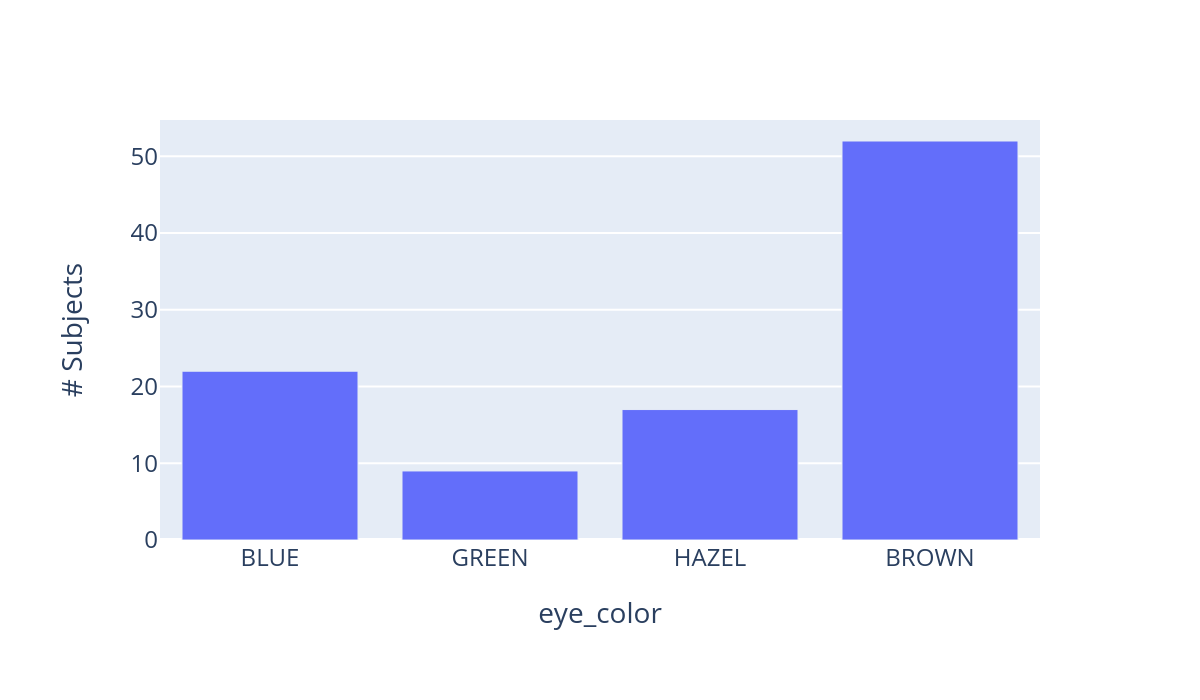

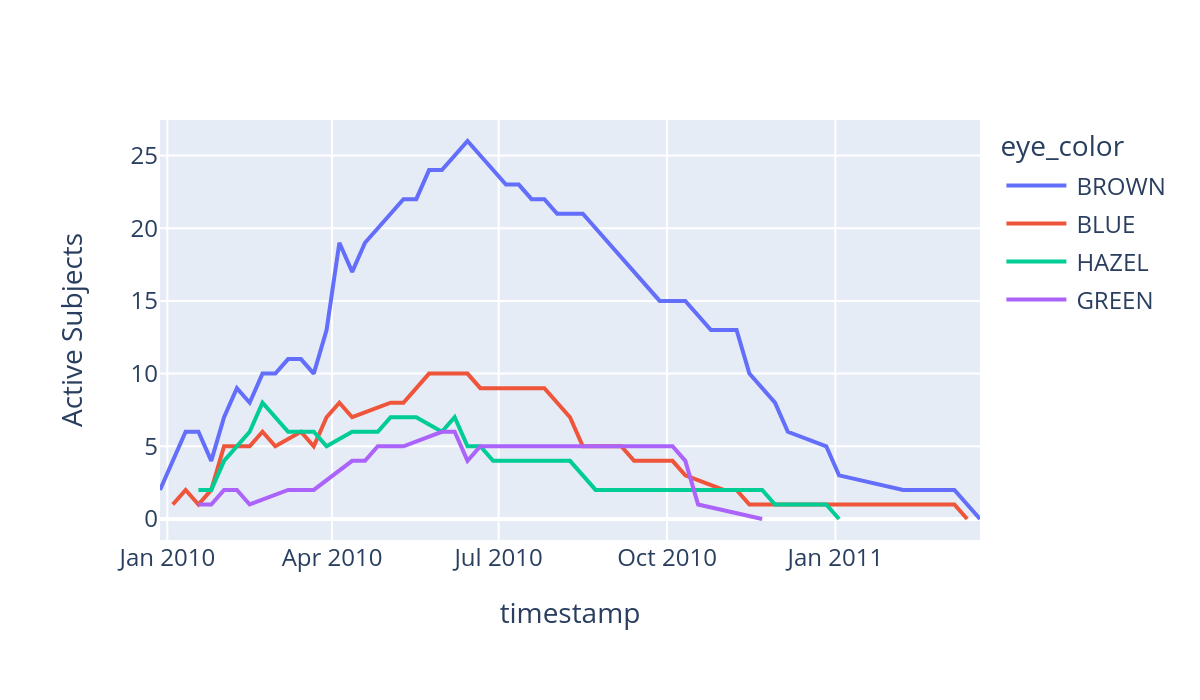

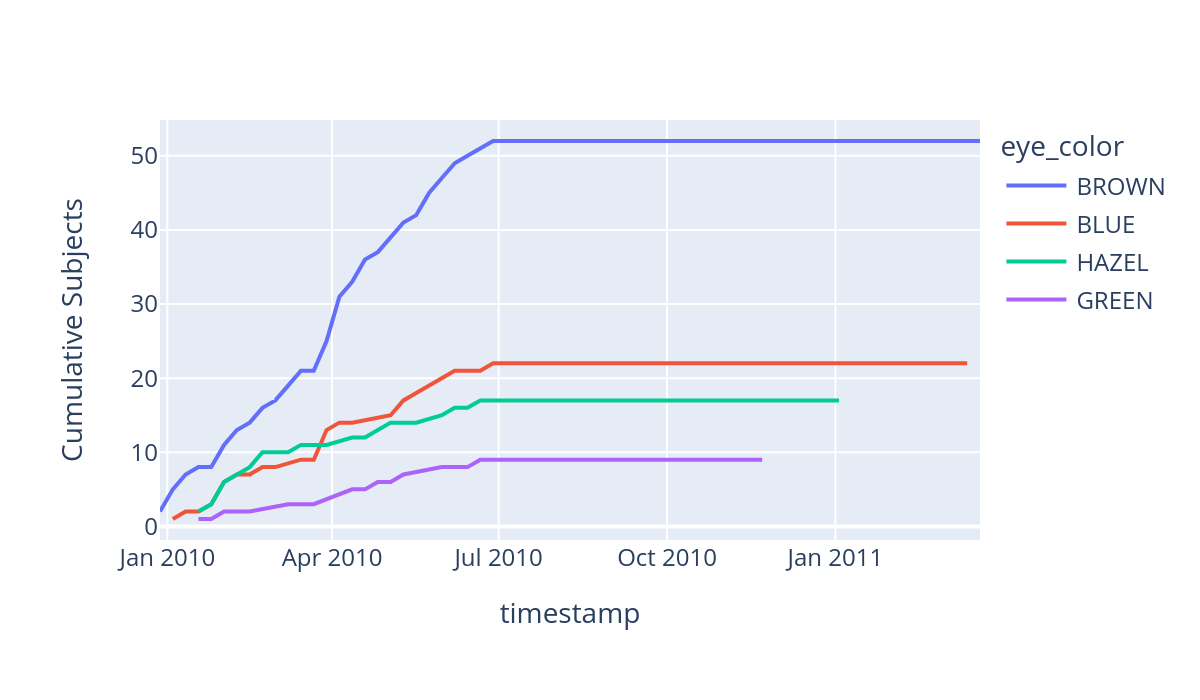

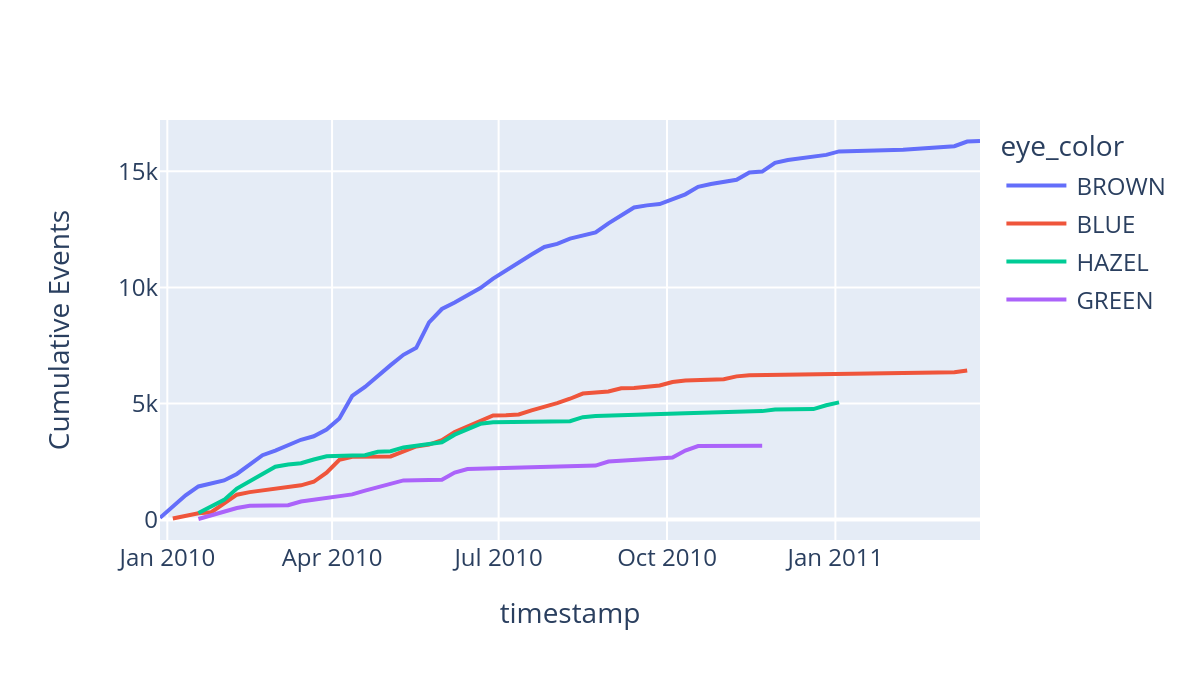

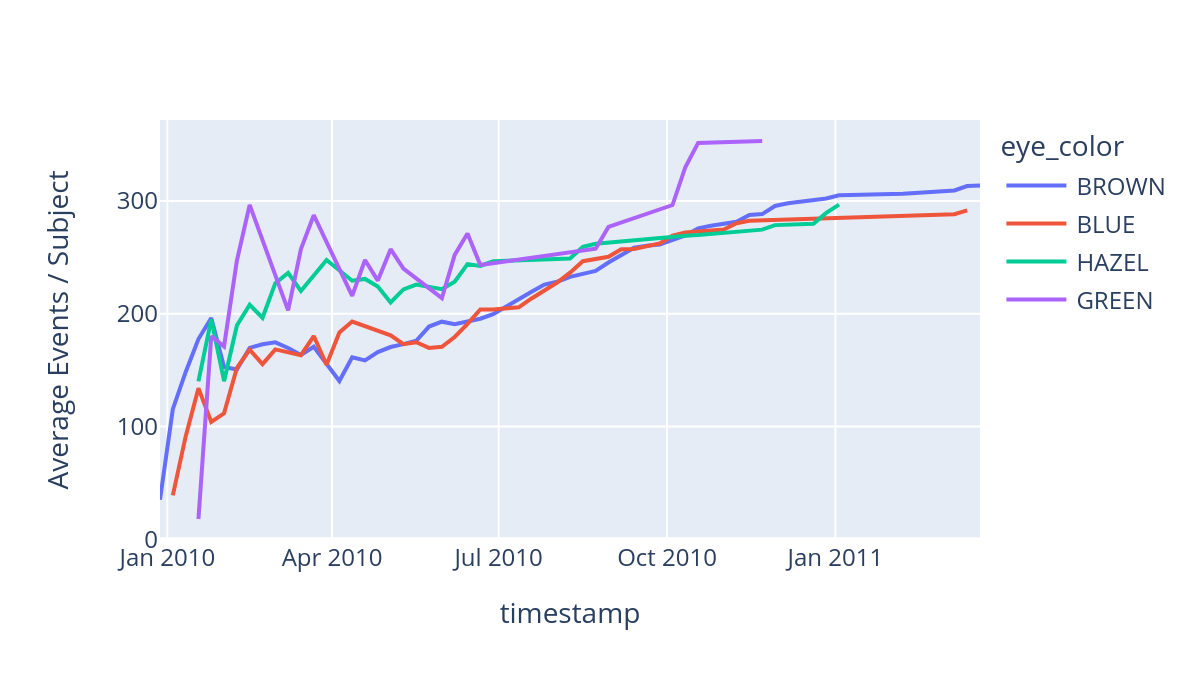

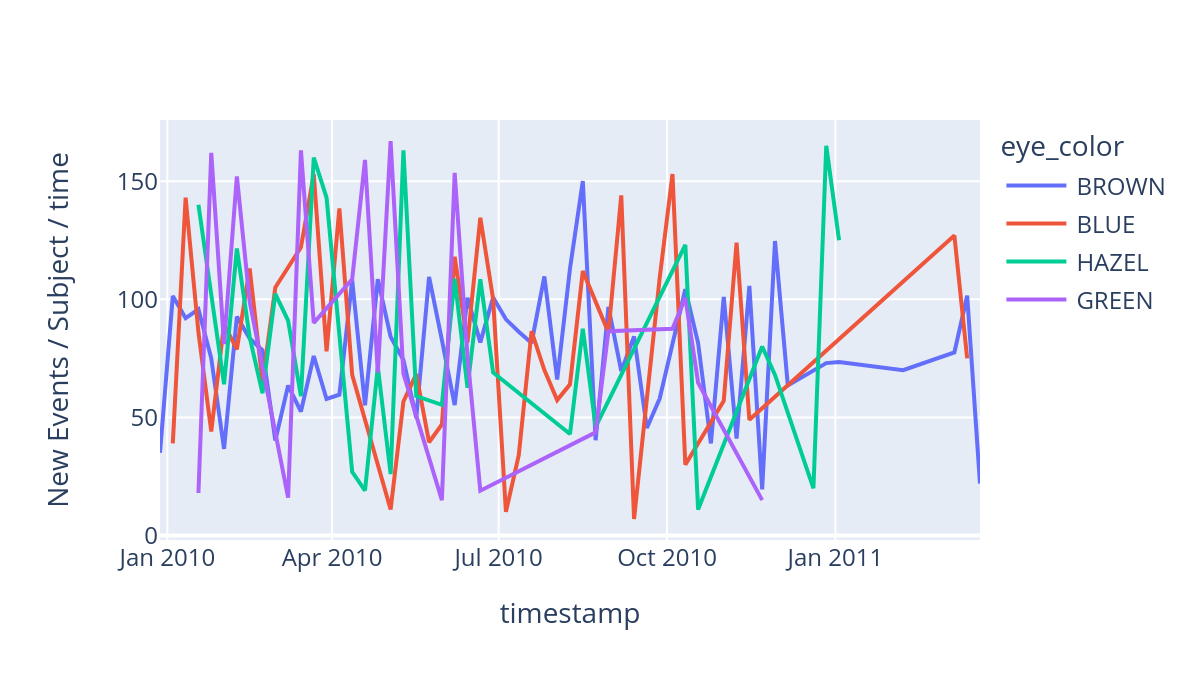

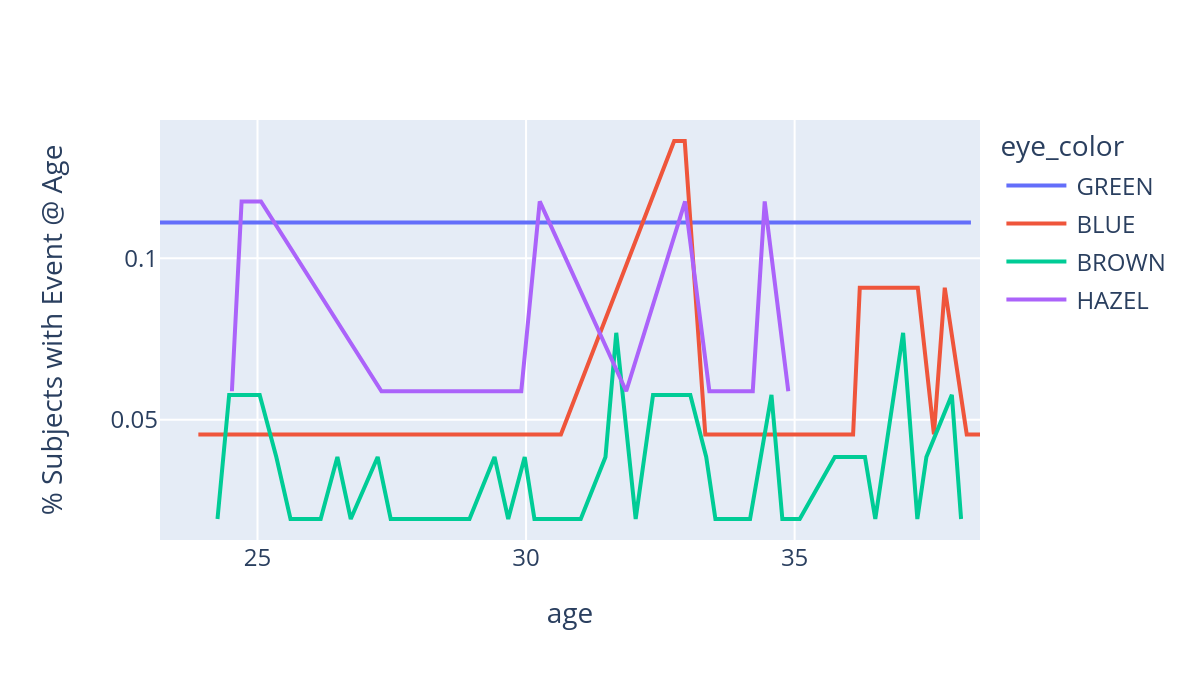

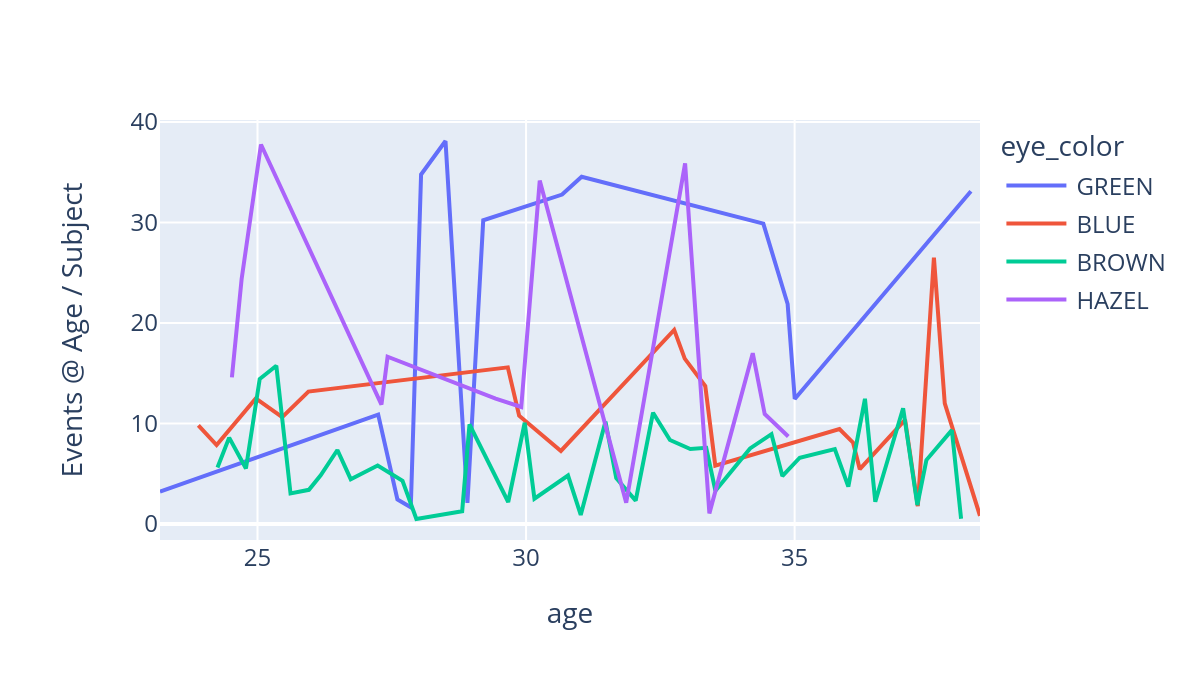

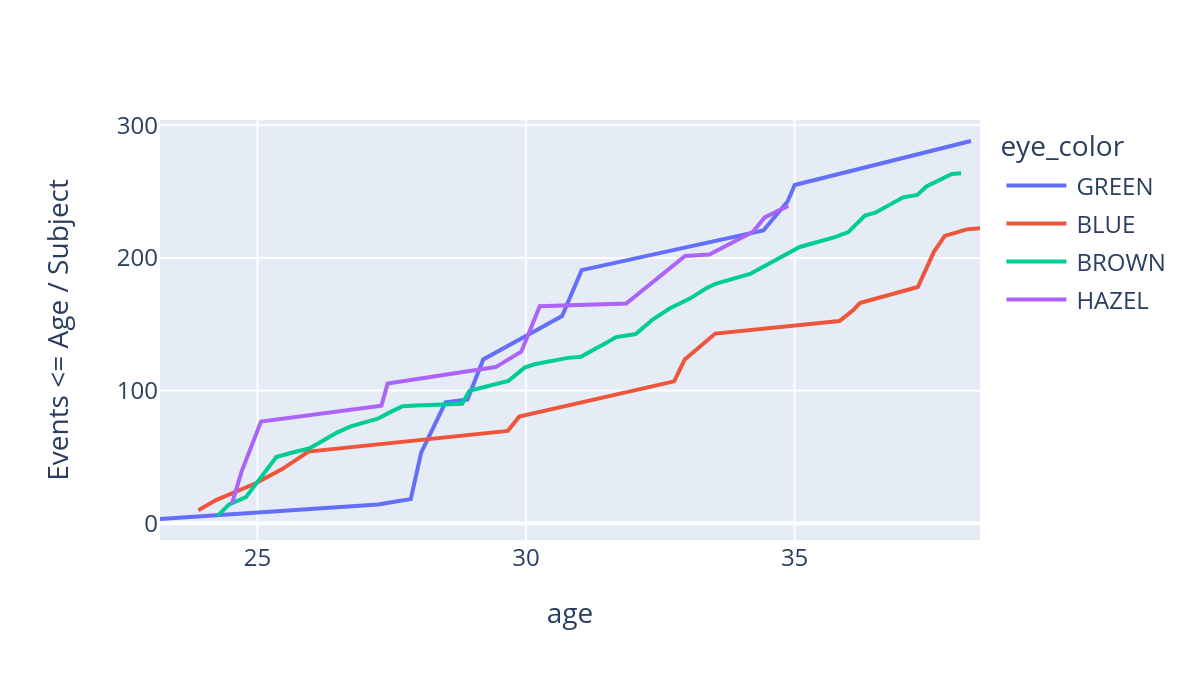

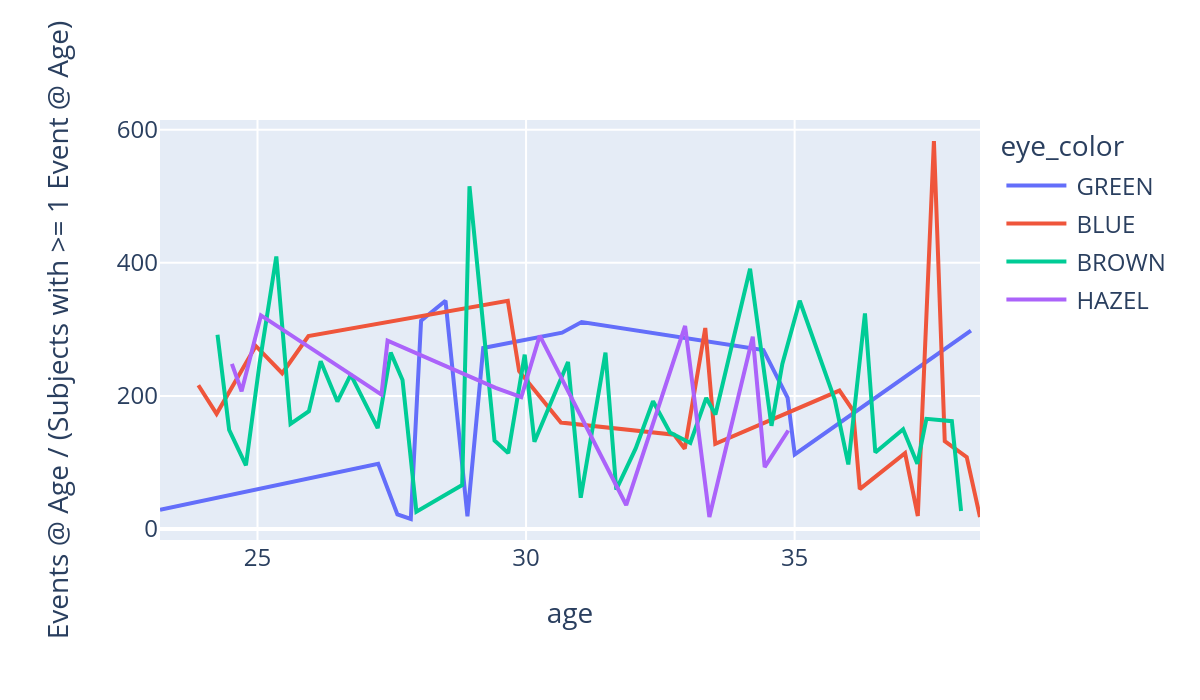

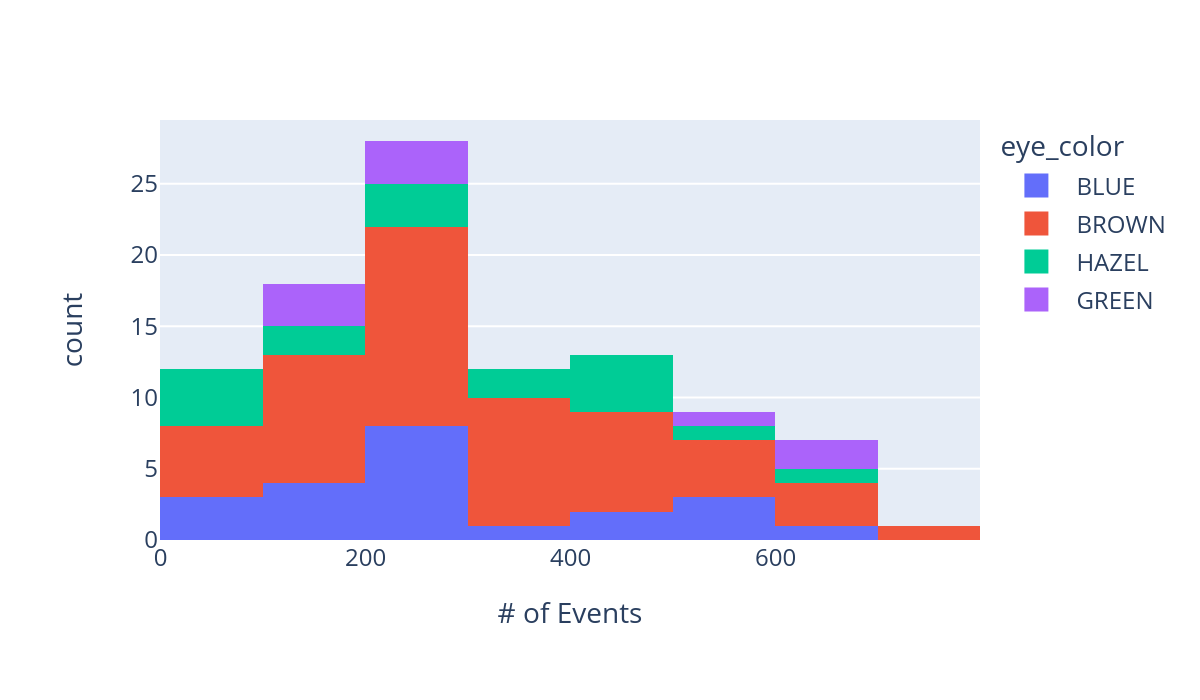

In [82]:
V = Visualizer(
    age_col='age', dob_col='dob', static_covariates=['eye_color'], plot_by_age=True, n_age_buckets=50,
    time_unit='1w'
)
figs = ESD.describe(viz_config=V)
for fig in figs:
    display(Image(fig.to_image(format="png", width=600, height=350, scale=2)))    

### Automatic Task Cohort Extraction
Thanks to great work by Justin Xu, ESGPT will also soon support automatic, config-driven task cohort extraction and zero-shot labeler creation. See https://github.com/justin13601/ESGPTTaskQueryingPublic for more details!

Task configs:
![Sample config](https://raw.githubusercontent.com/justin13601/ESGPTTaskQueryingPublic/master/TaskSchemaDefinition.svg)

## Training models

Next, we will show how you can train ESGPT style autoregressive models over these data. To begin, we need to know how these model architectures work:

### How do model architectures work?
To see how model architectures work, consider the video tutorial below:

<center>
<video width="70%" height="auto" 
       src="https://github.com/mmcdermott/EventStreamGPT/raw/main/sample_data/model_tutorial.mp4"  
       controls>
</video>
</center>

## Training models with built in scripts
Now that you know how model architectures operate, let's explore pre-training a toy model with the built-in pre-training script. It operates through a config file, much like the dataset building script does. Let's see one such config file now:

In [83]:
!cat sample_data/pretrain_CI.yaml

defaults:
  - pretrain_config
  - _self_

do_overwrite: false
seed: 1
config:
  do_use_learnable_sinusoidal_ATE: false
  do_split_embeddings: false
  static_embedding_mode: sum_all
  static_embedding_weight: 0.4
  dynamic_embedding_weight: 0.5
  do_normalize_by_measurement_index: false
  structured_event_processing_mode: conditionally_independent
  num_hidden_layers: 4
  seq_attention_types: ["global", "local"]
  seq_window_size: 4
  TTE_generation_layer_type: log_normal_mixture
  TTE_lognormal_generation_num_components: 2
  head_dim: 8
  num_attention_heads: 2
  attention_dropout: 0.2
  input_dropout: 0.2
  resid_dropout: 0.2
  intermediate_size: 128
optimization_config:
  init_lr: 0.0001
  end_lr_frac_of_init_lr: 0.01
  end_lr: null
  max_epochs: 2
  batch_size: 32
  validation_batch_size: 32
  lr_frac_warmup_steps: 0.05
  lr_decay_power: 2
  weight_decay: 0.2
  patience: null
  gradient_accumulation: null
  num_dataloader_workers: 1
data_config:
  save_dir: ???
  max_seq_len: 128
  

There are a variety of aspects to this config, including model parameters in the `config` section, optimization parameters in the `optimization_config` section, metrics specifications in the `pretraining_` and `final_validation_` `metrics_config` sections, PyTorch Lightning trainer parameters in the `trainer_config`, and weights and biases logger parameters in the `wandb_logger_kwargs` section.

To understand each of these different config section, inspect the documentation for the [generative modeling pre-training main function](https://eventstreamml.readthedocs.io/en/latest/api/EventStream.transformer.lightning_modules.generative_modeling.html) and the overall [model configuration classes](https://eventstreamml.readthedocs.io/en/latest/api/EventStream.transformer.config.html).

To run a pre-training model, we'll use the below script:

```bash
PYTHONPATH=$(pwd):$PYTHONPATH ./scripts/pretrain.py \
	--config-path="$(pwd)/sample_data/" \
	--config-name=pretrain_CI \
	"hydra.searchpath=[$(pwd)/configs]" \
    data_config.save_dir=$(pwd)/sample_data/processed/sample \
    experiment_dir=$(pwd)/sample_data/processed/PT_CI
```

In [84]:
command = """\
PYTHONPATH=$(pwd):$PYTHONPATH ./scripts/pretrain.py \
	--config-path="$(pwd)/sample_data/" \
	--config-name=pretrain_CI \
	"hydra.searchpath=[$(pwd)/configs]" \
    data_config.save_dir=$(pwd)/sample_data/processed/sample \
    experiment_dir=$(pwd)/sample_data/processed/PT_CI
"""

command_out = subprocess.run(command, shell=True, capture_output=True)
print(command_out.stdout.decode())

if command_out.returncode == 1:
    print("Command Errored!")

print(command_out.stderr.decode())

Epoch 0: 100%|██████████| 3/3 [00:01<00:00,  2.81it/s, v_num=0]            
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  3.01it/s, v_num=0]       
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          Validate metric                     DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
           tuning_HR_MSE                    3.221186399459839
         tuning_HR_reg_NLL                  3.493877410888672
          tuning_TTE_MSE                       112738808.0
          tuning_TTE_MSLE                  0.5375430583953857
        tuning_TTE_reg_NLL                  5.003767967224121
     tuning_department_cls_NLL             0.6850418448448181
 tuning_department_m

We can see that the model ran successfully, though of course on this synthetic data it does not learn any final validation metrics that indicate better than chance performance. With this, however, you have seen how to structure your own pre-training configuration file to run pre-training models yourself! Check back soon for more details on this process and for examples of other modeling tasks ESGPT supports, such as fine-tuning, hyperparameter tuning, and generation or zero-shot inference!